In [591]:
import pandas as pd
from Bio.Seq import Seq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica" #somethings this one doesnt work
plt.rcParams['pdf.fonttype'] = 42

# Phosphosite variants

Analysis plan:
1. Effect of phosphomutants relative to WT?
- Line plot of WT tiles vs phosphomutant tiles
2. Do the newly confirmed phosphosites (T96, T249 and T273) play a role in activity?
3. Do all confirmed PS contribute equally to activity? 
- Use single confirmed A (A1c1):
    - plot WT trace vs scatter of variants
    - And above, plot a bar graph with fold change of each variant 
4. Are there non-confirmed PS that contribute to activity? 
- Do predicted PS contribute to activity?: Full confirmed (A1c1) vs Full confirmed + predicted (A1b)
- Do other residues contribute to activity?: Full confirmed + predicted (A1b) vs maximal phospho mutant (A1a)
5. Is there an ordering when phosphorylation matters?
- Heatmap or scatter plot ??
6. Does the presence/lack of the aromatic ring in the substituent (Ala versus Phe) alter the outcome? 
- Scatter plot of A1a vs A2a
- Scatter plot of A1b vs A2b


# Helper function to get relevant rows of library

In [782]:
activity_col = "Activity_S3_1"

In [783]:
library = pd.read_excel("../margot_raw/SeqLib_Visit2_2023.xlsx", sheet_name = "Visit2")
library = library[["ProteinSeq", "Description", "Other"]]
library["Description"] = library["Description"].astype(str)
library

,ProteinSeq,Description,Other
0,STIPLDFMPRDALHGFDWSEEDDMSDGLPFLKTDPNNNGF,AD1_0,GAL4_AD1_0
1,STIPLDAMPRDALHGADASEEDDMSDGLPALKTDPNNNGA,AD1_Aro2A_0,GAL4_AD1_Aro2A_0
2,STIPADFMPRDAAHGFDWSEEDDMSDGAPFAKTDPNNNGF,AD1_L2A_0,GAL4_AD1_L2A_0
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,CAAD40_0,GCN4_CAAD40_0
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,CAAD40_WLF_A_0,GCN4_CAAD40_WLF_A_0
...,...,...,...
23344,EALSLCDDLDDEQDREENTNSGSLKDKQPCIADYAHLGPE,37_PSvsCHA_hyperE_DD_all,/
23345,DEQDREEDTNSGSLKDKQPCIADYAHLGPEDFKRDLEECQ,38_PSvsCHA_hyperE_DD_all,/
23346,IADYAHLGPEDFKRDLEECQKIVLDPSNDEDDEPPEDRDE,40_PSvsCHA_hyperE_DD_all,Pro subst
23347,DFKRDLEECQKIVLDPSNDEDDEPPEFRDEQDEFDEQDDF,41_PSvsCHA_hyperE_DD_all,Pro subst


In [784]:
def return_activities(description, pos_regex = r'(\d+)_.*'):
    library_rows = library[library["Description"].str.contains(description)]
    library_rows["Start"] = library_rows["Description"].str.extract(pos_regex).astype(int)
    library_rows["Start"] = 10 * library_rows["Start"] - 9
    library_rows.loc[library_rows['Start'] ==411, 'Start'] = 410
    library_rows["mid"] = library_rows["Start"] + 20
    library_rows["End"] = library_rows["Start"] + 40
    library_rows["tile"] = library_rows["ProteinSeq"].astype(str).str.strip()
    library_rows = library_rows.drop(columns = {"ProteinSeq"})
    
    activities = pd.read_csv("../data/Sog1_library2_activities_with_reads.csv")
    #activities = pd.read_csv("../data/Sog1_library2_activities_with_reads_ECspike.csv")
    #activities = pd.read_csv("../data/Sog1_library2_activities_with_reads_EC.csv")
    activities = activities.rename(columns = {"AAseq" : "tile"})
    activities["tile"] = activities["tile"].astype(str).str.strip()
      
    return pd.merge(library_rows, activities[["tile", "Activity_S3_1", "Activity_S3_2", "lib2_avg"]], on = "tile", how = "left")

# 1. Effect of phosphomutants relative to WT?

In [785]:
# Full confirmed phosphomutant tiles
PSv_conf2fA_STYA = return_activities("PSv_conf2fA_STYA")
PSv_conf2fA_STYA.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2fA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926
1,8_PSv_conf2fA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427
2,9_PSv_conf2fA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916


In [786]:
# WT tiles
BasicArTh = return_activities("BasicArTh", pos_regex = r'\.(\d+)')
BasicArTh.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,BasicArTh.1,Q6NQK2,1,21,41,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,349.798825,573.084946,461.441886
1,BasicArTh.2,Q6NQK2,11,31,51,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,470.700956,2417.845241,1444.273098
2,BasicArTh.3,Q6NQK2,21,41,61,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,867.654700,1328.781736,1098.218218


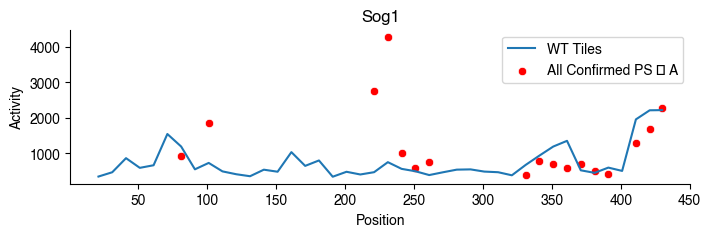

In [787]:
plt.figure(figsize = (8, 2))
sns.lineplot(data = BasicArTh, x = "mid", y = activity_col, label = "WT Tiles")
sns.scatterplot(data = PSv_conf2fA_STYA, x = "mid", y = activity_col, color = "red", label = "All Confirmed PS → A")
plt.title("Sog1")
plt.ylabel("Activity")
plt.xlabel("Position")
sns.despine()

# 2. Do the newly confirmed phosphosites (T96, T249 and T273) play a role in activity?

In [788]:
def find_difference_indices(str1, str2, adjust = 0):
    if type(str1) != str or type(str2) != str:
        return None
    # Initialize a list to store indices where characters differ
    diff_indices = []
    # Iterate over the characters of the strings and find all indices where they differ
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            diff_indices.append(i + adjust)
    
    # If the strings are of different lengths, add the remaining indices
    if len(str1) != len(str2):
        diff_indices.append(min(len(str1), len(str2)))
        print("warning: Diff lens")
        
    return diff_indices if diff_indices else None  # Return None if no differences are found

def add_var_positions(var_df, ref_df, activity_col):
    merged = pd.merge(var_df, ref_df, on = ["Start", "mid", "End"], how = "left", suffixes = ("_var", "_wt"))
    diffs = []
    for i in merged.index:
        diffs.append(find_difference_index(merged['tile_var'].iloc[i], 
                                        merged['tile_wt'].iloc[i]))

    merged["var"] = diffs
    merged["var"] = merged["var"] + merged["Start"]
    merged["activ_diff"] = merged[activity_col + "_var"] - merged[activity_col + "_wt"]
    merged["activ_fold_change"] = merged[activity_col + "_var"] / merged[activity_col + "_wt"]
    return merged


def add_all_var_positions(var_df, ref_df, activity_col):
    merged = pd.merge(var_df, ref_df, on = ["Start", "mid", "End"], how = "left", suffixes = ("_var", "_wt"))
    diffs = []
    for i in merged.index:
        diffs.append(find_difference_indices(merged['tile_var'].iloc[i], 
                                        merged['tile_wt'].iloc[i],
                                            merged['Start'].iloc[i]))

    merged["vars"] = diffs
    return merged
        
# Apply this function to each row in the DataFrame
# diffs = []
# for i in conf2sA_STYA_vs_basic.index:
#     diffs.append(find_difference_index(conf2sA_STYA_vs_basic['tile_var'].iloc[i], 
#                                        conf2sA_STYA_vs_basic['tile_wt'].iloc[i]))
# conf2sA_STYA_vs_basic["var"] = diffs
# conf2sA_STYA_vs_basic["var"] = conf2sA_STYA_vs_basic["var"] + conf2sA_STYA_vs_basic["Start_var"]
# conf2sA_STYA_vs_basic["activ_change"] = conf2sA_STYA_vs_basic["Activity_S3_1_var"] - conf2sA_STYA_vs_basic["Activity_S3_1_wt"]
# conf2sA_STYA_vs_basic

In [789]:
# Single confirmed phosphomutant tiles
PSv_confsA_STYA = return_activities("PSv_conf2sA_STYA")
PSv_confsA_STYA.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2sA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926
1,8_PSv_conf2sA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427
2,9_PSv_conf2sA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916


In [790]:
PSv_confsA_STYA_vs_basic = add_var_positions(PSv_confsA_STYA, BasicArTh, activity_col)
PSv_confsA_STYA_vs_basic.head(3)

,Description_var,Other_var,Start,mid,End,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,var,activ_diff,activ_fold_change
0,7_PSv_conf2sA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926,BasicArTh.7,Q6NQK2,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1195.592810,1693.562924,1444.577867,96,-257.309377,0.784785
1,8_PSv_conf2sA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427,BasicArTh.8,Q6NQK2,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,553.464718,495.706275,524.585497,96,NaN,NaN
2,9_PSv_conf2sA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916,BasicArTh.9,Q6NQK2,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,733.541576,756.101744,744.821660,96,1124.791786,2.533372


In [791]:
def plot_tile(start, end, activity, var, ax, color):
    ax.hlines(y=activity, xmin=start, xmax=end, color=color, lw = 1, alpha = 0.5, zorder = 0)
    sns.scatterplot(x = [(start + end) / 2], y = [activity], color = color, alpha = 1, ax = ax, s = 15, zorder = 1)
        
def plot_all_tiles(merged_df, y_col, ax, color = 'red'):
    for i in PSv_confsA_STYA_vs_basic.index:
        row = PSv_confsA_STYA_vs_basic.loc[i]
        plot_tile(row["Start"],
                  row["End"],
                  row[y_col],
                  row["var"], 
                  ax,
                 color = color)     

In [792]:
# plt.figure(figsize = (8, 2))

# plot_all_tiles(PSv_confsA_STYA_vs_basic, activity_col, color = 'gray')
# sns.scatterplot(data = PSv_confsA_STYA_vs_basic, 
#                 x = "var", 
#                 y = activity_col + "_var", 
#                 hue = "var", 
#                 legend = False, 
#                 palette = 'colorblind',
#                alpha = 1)

# sns.lineplot(data = BasicArTh, x = "mid", y = activity_col, label = "WT Tiles", lw = 2, legend = False)
# plt.xlim(1, 449)

# plt.ylabel("Activity")
# plt.xlabel("Position")
# sns.despine()

In [793]:
PSv_confsA_STYA_vs_basic["activ_log_fold_change"] = np.log(PSv_confsA_STYA_vs_basic["activ_fold_change"])
PSv_confsA_STYA_vs_basic

,Description_var,Other_var,Start,mid,End,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,var,activ_diff,activ_fold_change,activ_log_fold_change
0,7_PSv_conf2sA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926,BasicArTh.7,Q6NQK2,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1195.592810,1693.562924,1444.577867,96,-257.309377,0.784785,-0.242345
1,8_PSv_conf2sA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427,BasicArTh.8,Q6NQK2,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,553.464718,495.706275,524.585497,96,NaN,NaN,NaN
2,9_PSv_conf2sA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916,BasicArTh.9,Q6NQK2,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,733.541576,756.101744,744.821660,96,1124.791786,2.533372,0.929551
3,10_PSv_conf2sA_STYA,NaN,91,111,131,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,558.417688,558.417688,BasicArTh.10,Q6NQK2,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,495.092751,785.676325,640.384538,96,NaN,NaN,NaN
4,21_PSv_conf2sA_STYA,NaN,201,221,241,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVAPTA,2760.512552,2926.642543,2843.577547,BasicArTh.21,Q6NQK2,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVTPTA,472.388999,419.267250,445.828124,237,2288.123554,5.843727,1.765369
5,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVTPKLATP,NaN,NaN,NaN,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,237,NaN,NaN,NaN
6,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVAPKLATP,463.613666,1663.967954,1063.790810,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,244,-291.162915,0.614240,-0.487370
7,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLAAP,923.329508,NaN,923.329508,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,249,168.552927,1.223315,0.201564
8,23_PSv_conf2sA_STYA,NaN,221,241,261,GDKAEQEVSEDIFAAVAPTADPVTPKLATPEPRNAVRICS,NaN,NaN,NaN,BasicArTh.23,Q6NQK2,GDKAEQEVSEDIFAAVTPTADPVTPKLATPEPRNAVRICS,566.063618,959.486272,762.774945,237,NaN,NaN,NaN
9,23_PSv_conf2sA_STYA,NaN,221,241,261,GDKAEQEVSEDIFAAVTPTADPVAPKLATPEPRNAVRICS,496.086024,514.989166,505.537595,BasicArTh.23,Q6NQK2,GDKAEQEVSEDIFAAVTPTADPVTPKLATPEPRNAVRICS,566.063618,959.486272,762.774945,244,-69.977594,0.876379,-0.131957


In [794]:
# plt.figure(figsize = (8, 2))
# plt.axhline(y = 1, color = "gray")
# sns.scatterplot(data = PSv_confsA_STYA_vs_basic, 
#                 x = "var", 
#                 y = "activ_fold_change", 
#                 hue = "var", 
#                 legend = False, 
#                 palette = 'colorblind',
#                alpha = 1)
# plt.xlim(1, 449)
# sns.despine()

In [795]:
# plt.figure(figsize = (8, 2))
# plt.axhline(y = 0, color = "gray")
# sns.scatterplot(data = PSv_confsA_STYA_vs_basic, 
#                 x = "var", 
#                 y = "activ_log_fold_change", 
#                 hue = "var", 
#                 legend = False, 
#                 palette = 'colorblind',
#                alpha = 1)
# plt.ylabel("Log-fold\nActivity\nChange", rotation = 0, labelpad = 20, va = "center")
# plt.xlim(1, 449)
# sns.despine()

In [796]:
PSv_confsA_STYA_vs_basic[["var", "activ_log_fold_change"]].groupby("var").mean()

,activ_log_fold_change
var,
96,0.343603
237,0.868272
244,-0.064004
249,0.900917
350,-0.236032
356,-0.420101
372,-0.051353
423,-0.195164
430,-0.101710


In [797]:
import colorcet as cc

In [798]:
palette = sns.color_palette(cc.glasbey_hv, n_colors = 13)
palette

[(0.188235, 0.635294, 0.854902),
 (0.988235, 0.309804, 0.188235),
 (0.898039, 0.682353, 0.219608),
 (0.427451, 0.564706, 0.309804),
 (0.545098, 0.545098, 0.545098),
 (0.090196, 0.745098, 0.811765),
 (0.580392, 0.403922, 0.741176),
 (0.839216, 0.152941, 0.156863),
 (0.121569, 0.466667, 0.705882),
 (0.890196, 0.466667, 0.760784),
 (0.54902, 0.337255, 0.294118),
 (0.737255, 0.741176, 0.133333),
 (0.227451, 0.003922, 0.513725)]

(-1.6, 1.6)

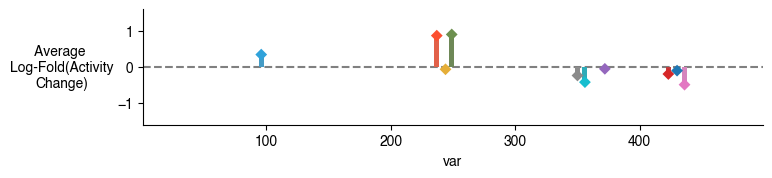

In [799]:
plt.figure(figsize = (8, 1.5))
plt.axhline(0, color = "gray", linestyle = "--", zorder = 0)

sns.barplot(data=PSv_confsA_STYA_vs_basic[["var", "activ_log_fold_change"]].groupby("var").mean(), 
                x="var", 
                y="activ_log_fold_change", 
                hue="var", 
                legend=False, 
                palette=palette,
                alpha=1, 
                edgecolor = "none", 
                native_scale = True)

sns.scatterplot(data=PSv_confsA_STYA_vs_basic[["var", "activ_log_fold_change"]].groupby("var").mean(), 
                x="var", 
                y="activ_log_fold_change", 
                hue="var", 
                legend=False, 
                palette=palette,
                alpha=1, marker = "D", edgecolor = "none")


plt.ylabel("Average \nLog-Fold(Activity\nChange)", rotation = 0, labelpad = 40, va = 'center')
sns.despine()
plt.xlim(1, 499)
plt.ylim(-1.6, 1.6)

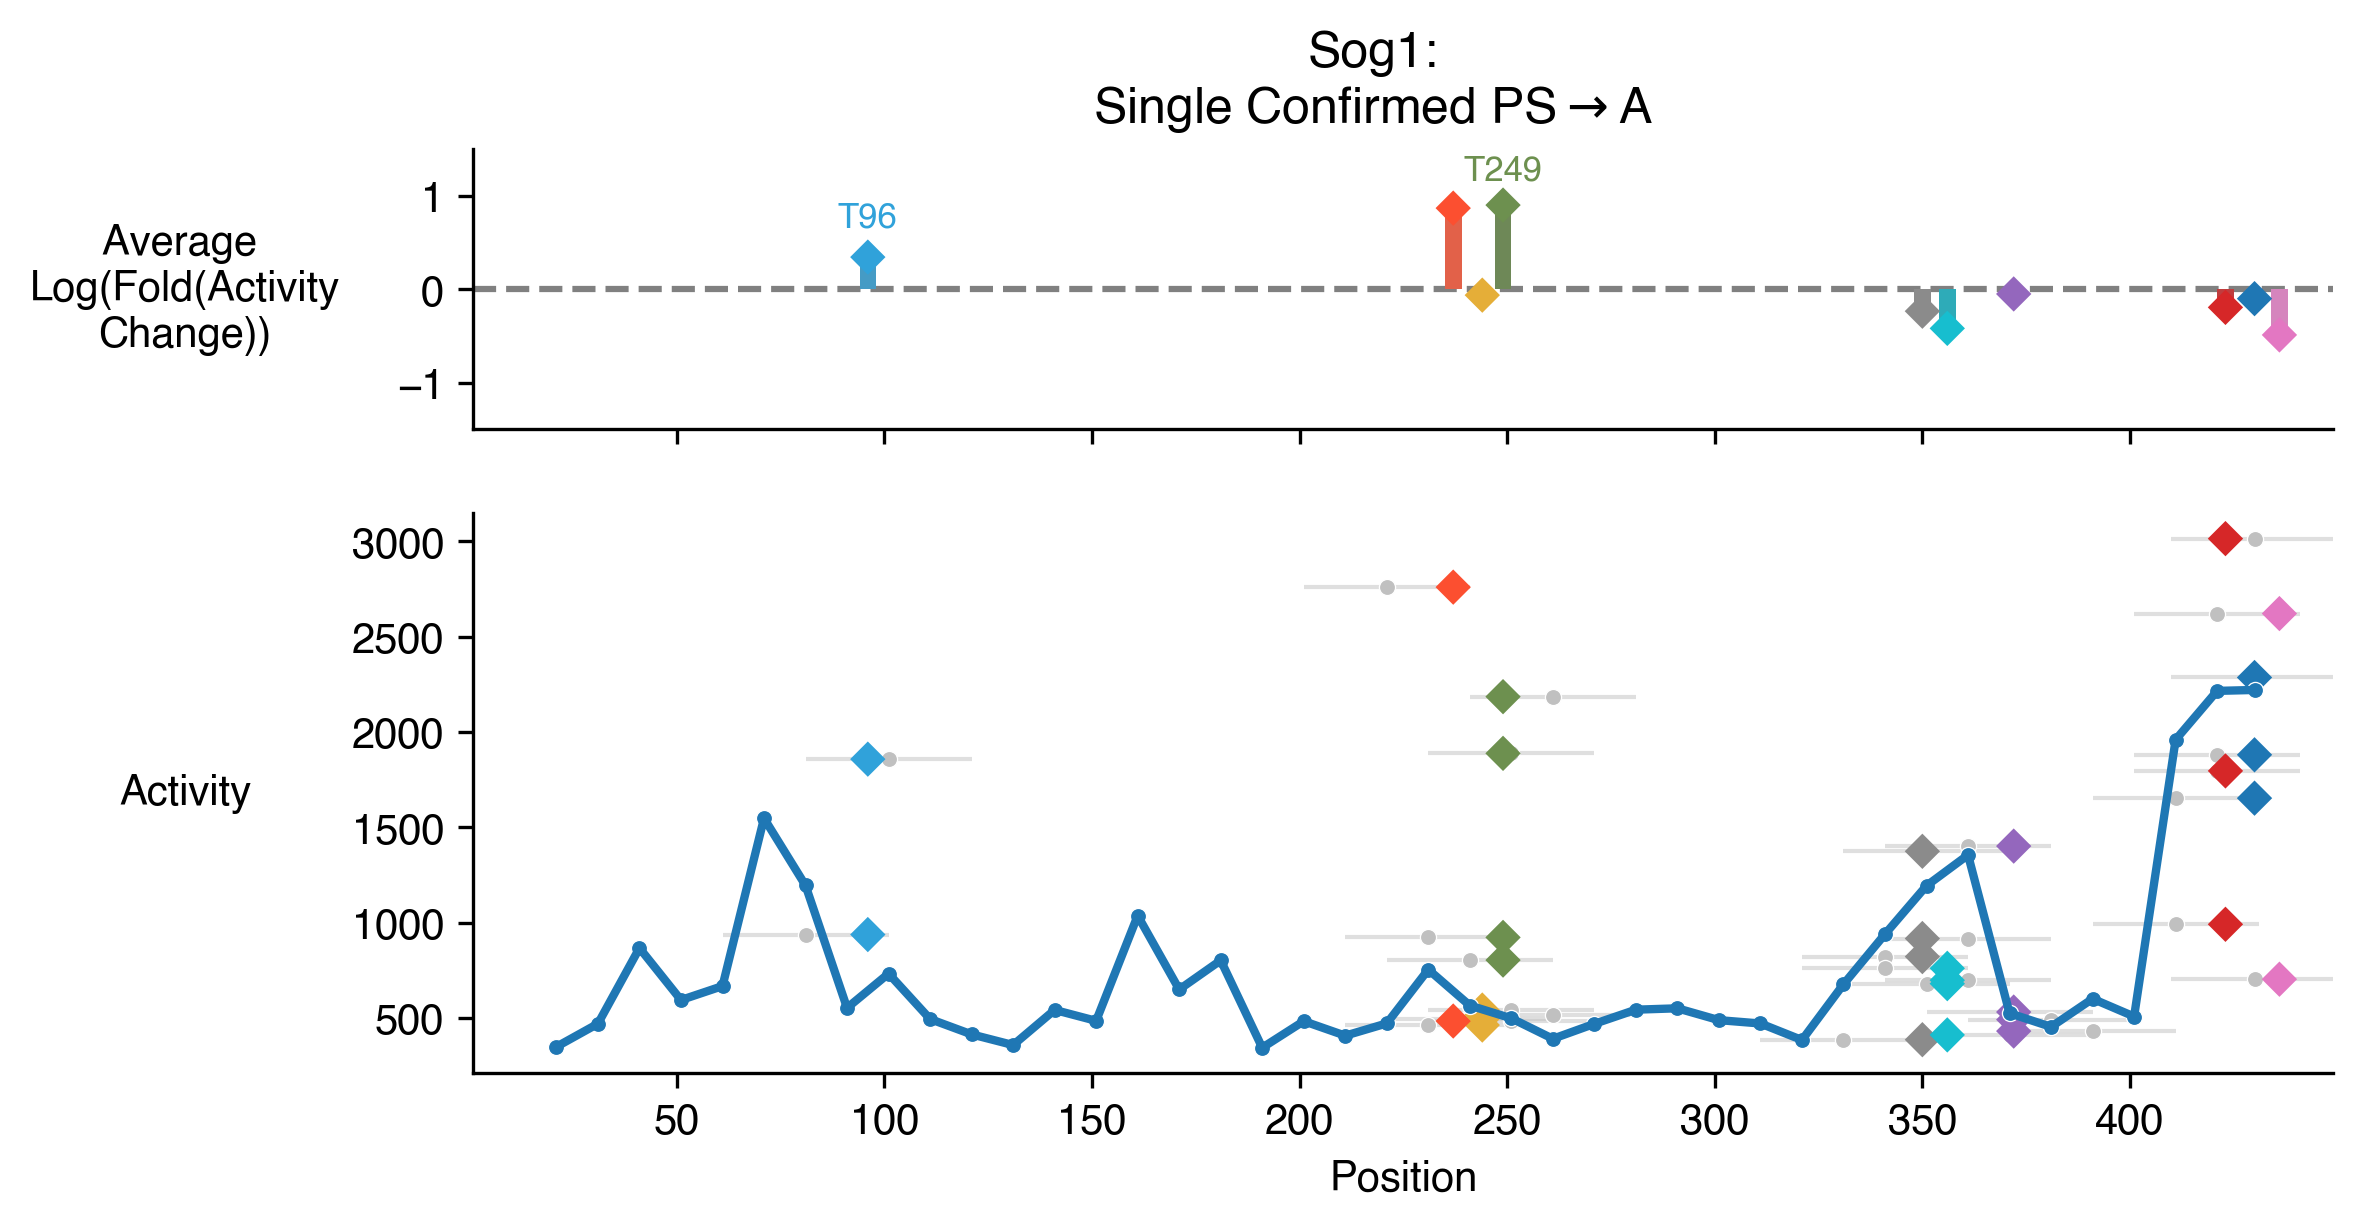

In [800]:
# Create a 2-row subplot with shared x-axis
fig, axs = plt.subplots(2, 1, figsize=(8, 4), sharex=True, gridspec_kw = {'height_ratios' : [1, 2]}, dpi = 300)

# Plot part 1
# axs[0].axhline(y=0, color="black", zorder = 0, linestyle = "--", lw = 1)
# plot_all_tiles(PSv_confsA_STYA_vs_basic, 
#                "activ_log_fold_change", 
#                ax=axs[0], 
#                color='silver')

# sns.scatterplot(data=PSv_confsA_STYA_vs_basic, 
#                 x="var", 
#                 y="activ_log_fold_change", 
#                 hue="var", 
#                 legend=False, 
#                 palette='colorblind',
#                 alpha=1, ax=axs[0], marker = "D", edgecolor = "none")
# axs[0].set_ylabel("Log\n(Activity-fold\nChange)", rotation=0, labelpad=20, va="center")
# axs[0].set_xlim(1, 449)

# sns.despine(ax=axs[0])

axs[0].axhline(0, color = "gray", linestyle = "--", zorder = 0)

avg_log_fold = PSv_confsA_STYA_vs_basic[["var", "activ_log_fold_change"]].groupby("var").mean()
sns.barplot(data=avg_log_fold, 
                x="var", 
                y="activ_log_fold_change", 
                hue="var", 
                legend=False, 
                palette=palette,
                alpha=1, 
                edgecolor = "none", 
                native_scale = True, ax = axs[0])

sns.scatterplot(data=avg_log_fold, 
                x="var", 
                y="activ_log_fold_change", 
                hue="var", 
                legend=False, 
                palette=palette,
                alpha=1, marker = "D", edgecolor = "none", ax = axs[0])


axs[0].set_ylabel("Average \nLog(Fold(Activity\nChange))", rotation = 0, labelpad = 40, va = 'center')
sns.despine(ax = axs[0])
axs[0].set_xlim(1, 499)
axs[0].set_ylim(-1.5, 1.5)

axs[0].text(96, 0.6, s = r"T96", ha = "center", va = "bottom", fontsize = 'small', color = palette[0])
axs[0].text(249, 1.1, s = r"T249", ha = "center", va = "bottom", fontsize = 'small', color = palette[3])
#axs[0].text(273, 0.5, s = r"$\bigstar$T273", ha = "center", va = "bottom", fontsize = 'small')

#axs[0].legend(bbox_to_anchor = (1.2,1.4), title = "   Mutated\nPhosphosite")

# Plot part 2
plot_all_tiles(PSv_confsA_STYA_vs_basic, activity_col + "_var", ax=axs[1], color='silver')
sns.scatterplot(data=PSv_confsA_STYA_vs_basic, 
                x="var", 
                y=activity_col + "_var", 
                hue="var", 
                legend=False, 
                palette=palette,
                alpha=1, ax=axs[1], marker = "D", edgecolor = "none")

sns.lineplot(data=BasicArTh, x="mid", y=activity_col, label="WT Tiles", lw=2, ax=axs[1], legend = False)

sns.scatterplot(data=BasicArTh, 
                x="mid", 
                y=activity_col, 
                legend=False, 
                alpha=1, 
                ax=axs[1], 
                color = sns.color_palette('tab10')[0], 
                s = 15)


axs[1].set_xlim(1, 449)
axs[1].set_ylabel("Activity", rotation = 0, labelpad = 40, va = 'center')
axs[1].set_xlabel("Position")
sns.despine(ax=axs[1])
#axs[1].legend(bbox_to_anchor = (1.22, 0.1), labelspacing = 0)

# Adjust layout for better spacing

fig.align_ylabels(axs)
plt.suptitle("Sog1:\nSingle Confirmed PS$\\rightarrow$A")
#plt.tight_layout()
# Show the figure
plt.show()


# 3. Are there non-confirmed PS that contribute to activity?

# 4. Is there an ordering when phosphorylation matters?

In [801]:
PSv_conf2cA_STYA = return_activities("PSv_conf2cA_STYA")
PSv_conf2cA_STYA.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2cA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926
1,8_PSv_conf2cA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427
2,9_PSv_conf2cA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916


In [802]:
PSv_conf2cA_STYA_vs_basic = add_all_var_positions(PSv_conf2cA_STYA, BasicArTh, activity_col)
PSv_conf2cA_STYA_vs_basic

,Description_var,Other_var,Start,mid,End,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,vars
0,7_PSv_conf2cA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926,BasicArTh.7,Q6NQK2,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1195.592810,1693.562924,1444.577867,[96]
1,8_PSv_conf2cA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427,BasicArTh.8,Q6NQK2,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,553.464718,495.706275,524.585497,[96]
2,9_PSv_conf2cA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916,BasicArTh.9,Q6NQK2,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,733.541576,756.101744,744.821660,[96]
3,10_PSv_conf2cA_STYA,NaN,91,111,131,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,558.417688,558.417688,BasicArTh.10,Q6NQK2,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,495.092751,785.676325,640.384538,[96]
4,21_PSv_conf2cA_STYA,NaN,201,221,241,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVAPTA,2760.512552,2926.642543,2843.577547,BasicArTh.21,Q6NQK2,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVTPTA,472.388999,419.267250,445.828124,[237]
5,22_PSv_conf2cA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVAPKLATP,433.167326,327.373221,380.270274,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,"[237, 244]"
6,22_PSv_conf2cA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVTPKLAAP,2149.994714,2332.816811,2241.405763,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,"[237, 249]"
7,22_PSv_conf2cA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVAPKLAAP,1155.997634,1248.266452,1202.132043,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,"[244, 249]"
8,22_PSv_conf2cA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVAPKLAAP,4289.037326,4376.962285,4332.999805,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,"[237, 244, 249]"
9,23_PSv_conf2cA_STYA,NaN,221,241,261,GDKAEQEVSEDIFAAVAPTADPVAPKLATPEPRNAVRICS,NaN,NaN,NaN,BasicArTh.23,Q6NQK2,GDKAEQEVSEDIFAAVTPTADPVTPKLATPEPRNAVRICS,566.063618,959.486272,762.774945,"[237, 244]"


In [803]:
PSv_conf2cA_STYA_vs_basic["vars"].value_counts()

vars
[96]               4
[244, 249]         4
[237, 244]         3
[237, 249]         3
[237, 244, 249]    3
[350, 356]         3
[423, 430]         3
[356, 372]         2
[372]              2
[423, 436]         2
[430, 436]         2
[423, 430, 436]    2
[237]              1
[350]              1
[350, 372]         1
[350, 356, 372]    1
Name: count, dtype: int64

In [804]:
PSv_conf2cA_STYA_vs_basic["Start"].value_counts()

Start
410    4
401    4
211    4
221    4
231    4
341    4
331    1
391    1
371    1
361    1
351    1
61     1
321    1
71     1
241    1
201    1
91     1
81     1
311    1
Name: count, dtype: int64

In [805]:
PSv_conf2cA_STYA_vs_basic["vars_str"] = PSv_conf2cA_STYA_vs_basic["vars"].astype(str)
PSv_conf2cA_STYA_vs_basic["var_count"] = PSv_conf2cA_STYA_vs_basic["vars_str"].str.count(",") + 1
PSv_conf2cA_STYA_vs_basic[["Start", "vars_str"]].value_counts()

Start  vars_str       
61     [96]               1
321    [350, 356]         1
341    [350, 356, 372]    1
       [350, 356]         1
       [350, 372]         1
       [356, 372]         1
351    [356, 372]         1
361    [372]              1
371    [372]              1
391    [423, 430]         1
401    [423, 430, 436]    1
       [423, 430]         1
       [423, 436]         1
       [430, 436]         1
410    [423, 430, 436]    1
       [423, 430]         1
       [423, 436]         1
331    [350, 356]         1
311    [350]              1
71     [96]               1
241    [244, 249]         1
81     [96]               1
91     [96]               1
201    [237]              1
211    [237, 244, 249]    1
       [237, 244]         1
       [237, 249]         1
       [244, 249]         1
221    [237, 244, 249]    1
       [237, 244]         1
       [237, 249]         1
       [244, 249]         1
231    [237, 244, 249]    1
       [237, 244]         1
       [237, 249]        

In [817]:
PSv_conf2sA_STYA = return_activities("PSv_conf2sA_STYA")
PSv_conf2sA_STYA_vs_basic = add_var_positions(PSv_conf2sA_STYA, BasicArTh, activity_col)
PSv_conf2sA_STYA_vs_basic

,Description_var,Other_var,Start,mid,End,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,var,activ_diff,activ_fold_change
0,7_PSv_conf2sA_STYA,NaN,61,81,101,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,938.283433,835.266419,886.774926,BasicArTh.7,Q6NQK2,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1195.592810,1693.562924,1444.577867,96,-257.309377,0.784785
1,8_PSv_conf2sA_STYA,NaN,71,91,111,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,1959.887427,1959.887427,BasicArTh.8,Q6NQK2,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,553.464718,495.706275,524.585497,96,NaN,NaN
2,9_PSv_conf2sA_STYA,NaN,81,101,121,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1858.333362,1904.584471,1881.458916,BasicArTh.9,Q6NQK2,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,733.541576,756.101744,744.821660,96,1124.791786,2.533372
3,10_PSv_conf2sA_STYA,NaN,91,111,131,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,558.417688,558.417688,BasicArTh.10,Q6NQK2,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,495.092751,785.676325,640.384538,96,NaN,NaN
4,21_PSv_conf2sA_STYA,NaN,201,221,241,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVAPTA,2760.512552,2926.642543,2843.577547,BasicArTh.21,Q6NQK2,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVTPTA,472.388999,419.267250,445.828124,237,2288.123554,5.843727
5,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVTPKLATP,NaN,NaN,NaN,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,237,NaN,NaN
6,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVAPKLATP,463.613666,1663.967954,1063.790810,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,244,-291.162915,0.614240
7,22_PSv_conf2sA_STYA,NaN,211,231,251,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLAAP,923.329508,NaN,923.329508,BasicArTh.22,Q6NQK2,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLATP,754.776581,850.860928,802.818754,249,168.552927,1.223315
8,23_PSv_conf2sA_STYA,NaN,221,241,261,GDKAEQEVSEDIFAAVAPTADPVTPKLATPEPRNAVRICS,NaN,NaN,NaN,BasicArTh.23,Q6NQK2,GDKAEQEVSEDIFAAVTPTADPVTPKLATPEPRNAVRICS,566.063618,959.486272,762.774945,237,NaN,NaN
9,23_PSv_conf2sA_STYA,NaN,221,241,261,GDKAEQEVSEDIFAAVTPTADPVAPKLATPEPRNAVRICS,496.086024,514.989166,505.537595,BasicArTh.23,Q6NQK2,GDKAEQEVSEDIFAAVTPTADPVTPKLATPEPRNAVRICS,566.063618,959.486272,762.774945,244,-69.977594,0.876379


In [1252]:
start = 410

def plot_combination_activities(start, spacing = 100, title_spacing = 450):
    plt.figure(dpi = 300)
    single_tile_df = PSv_conf2cA_STYA_vs_basic[PSv_conf2cA_STYA_vs_basic["Start"] == start]    
    all_row = single_tile_df[single_tile_df["var_count"] == 3]
    tile_vars = all_row["vars"].iloc[0]
    
    var_combo = list(single_tile_df["vars"])
    activities = list(single_tile_df[activity_col + "_var"])
    
    for var in tile_vars:
        row = PSv_conf2sA_STYA_vs_basic[(PSv_conf2sA_STYA_vs_basic["var"] == var) & (PSv_conf2sA_STYA_vs_basic["Start"] == start)]
        var_combo.append(row["var"].iloc[0])
        activities.append(row[activity_col + "_var"].iloc[0])
    
    var_combo.append("WT")
    activities.append(single_tile_df[activity_col + "_wt"].iloc[0])
        
    activities_df = pd.DataFrame({"combo" : var_combo,
                  activity_col : activities})
    activities_df["count"] = activities_df["combo"].astype(str).str.count(",") + 1
    activities_df = activities_df.sort_values(by = "count", ascending = False)
    activities_df["combo_str"] = activities_df["combo"].astype(str)
    activities_df.loc[activities_df['combo'] == "WT", 'count'] = 0

    
    sns.set_context('talk')
    ax = sns.barplot(data = activities_df, x = activity_col, y = "combo_str", hue = "count", legend = False, palette = "flare")
    plt.axhline(0.5, color = "silver", linestyle = "--")
    plt.axhline(3.5, color = "silver", linestyle = "--")
    plt.axhline(6.5, color = "silver", linestyle = "--")
    sns.despine()
    #plt.ylabel("PS$\\rightarrow$A", rotation = 0, labelpad = 600)
    plt.ylabel("Tile", labelpad = title_spacing)
    plt.xlabel("Activity")
    plt.title("Combinatorial Phosphomutants:\nTile " + str(start) + "-" + str(start+40))

    for j in activities_df.index:
        tile_aas = list(sog1_aa_features.iloc[start : start + 40]["aa"])
        mut_aas = activities_df["combo"].iloc[j]

        if isinstance(mut_aas, np.int64):
            mut_aas = np.array([mut_aas])

        
        for i in range(len(tile_aas)):
            facecolor='white'
            highlight = 'white'
            AA = tile_aas[i]
            if type(mut_aas) == str:
                color = "silver"
            elif i + start + 1 in mut_aas:
                color = "black"
                facecolor = 'red'
                AA = "A"
            else:
                color = "silver"
            
            plt.text(-1 * spacing * i - spacing * 1.5, j, AA, ha = "center", va = "center", color = color, fontsize = "small", bbox=dict(facecolor=facecolor, 
                                                                                                                                alpha=1, 
                                                                                                                                edgecolor = 'none', 
                                                                                                                               pad = 0.2))

    plt.gca().tick_params(axis='y', labelleft=False)


In [1253]:
len(tile_aas)

39

In [1254]:
type(10)

int

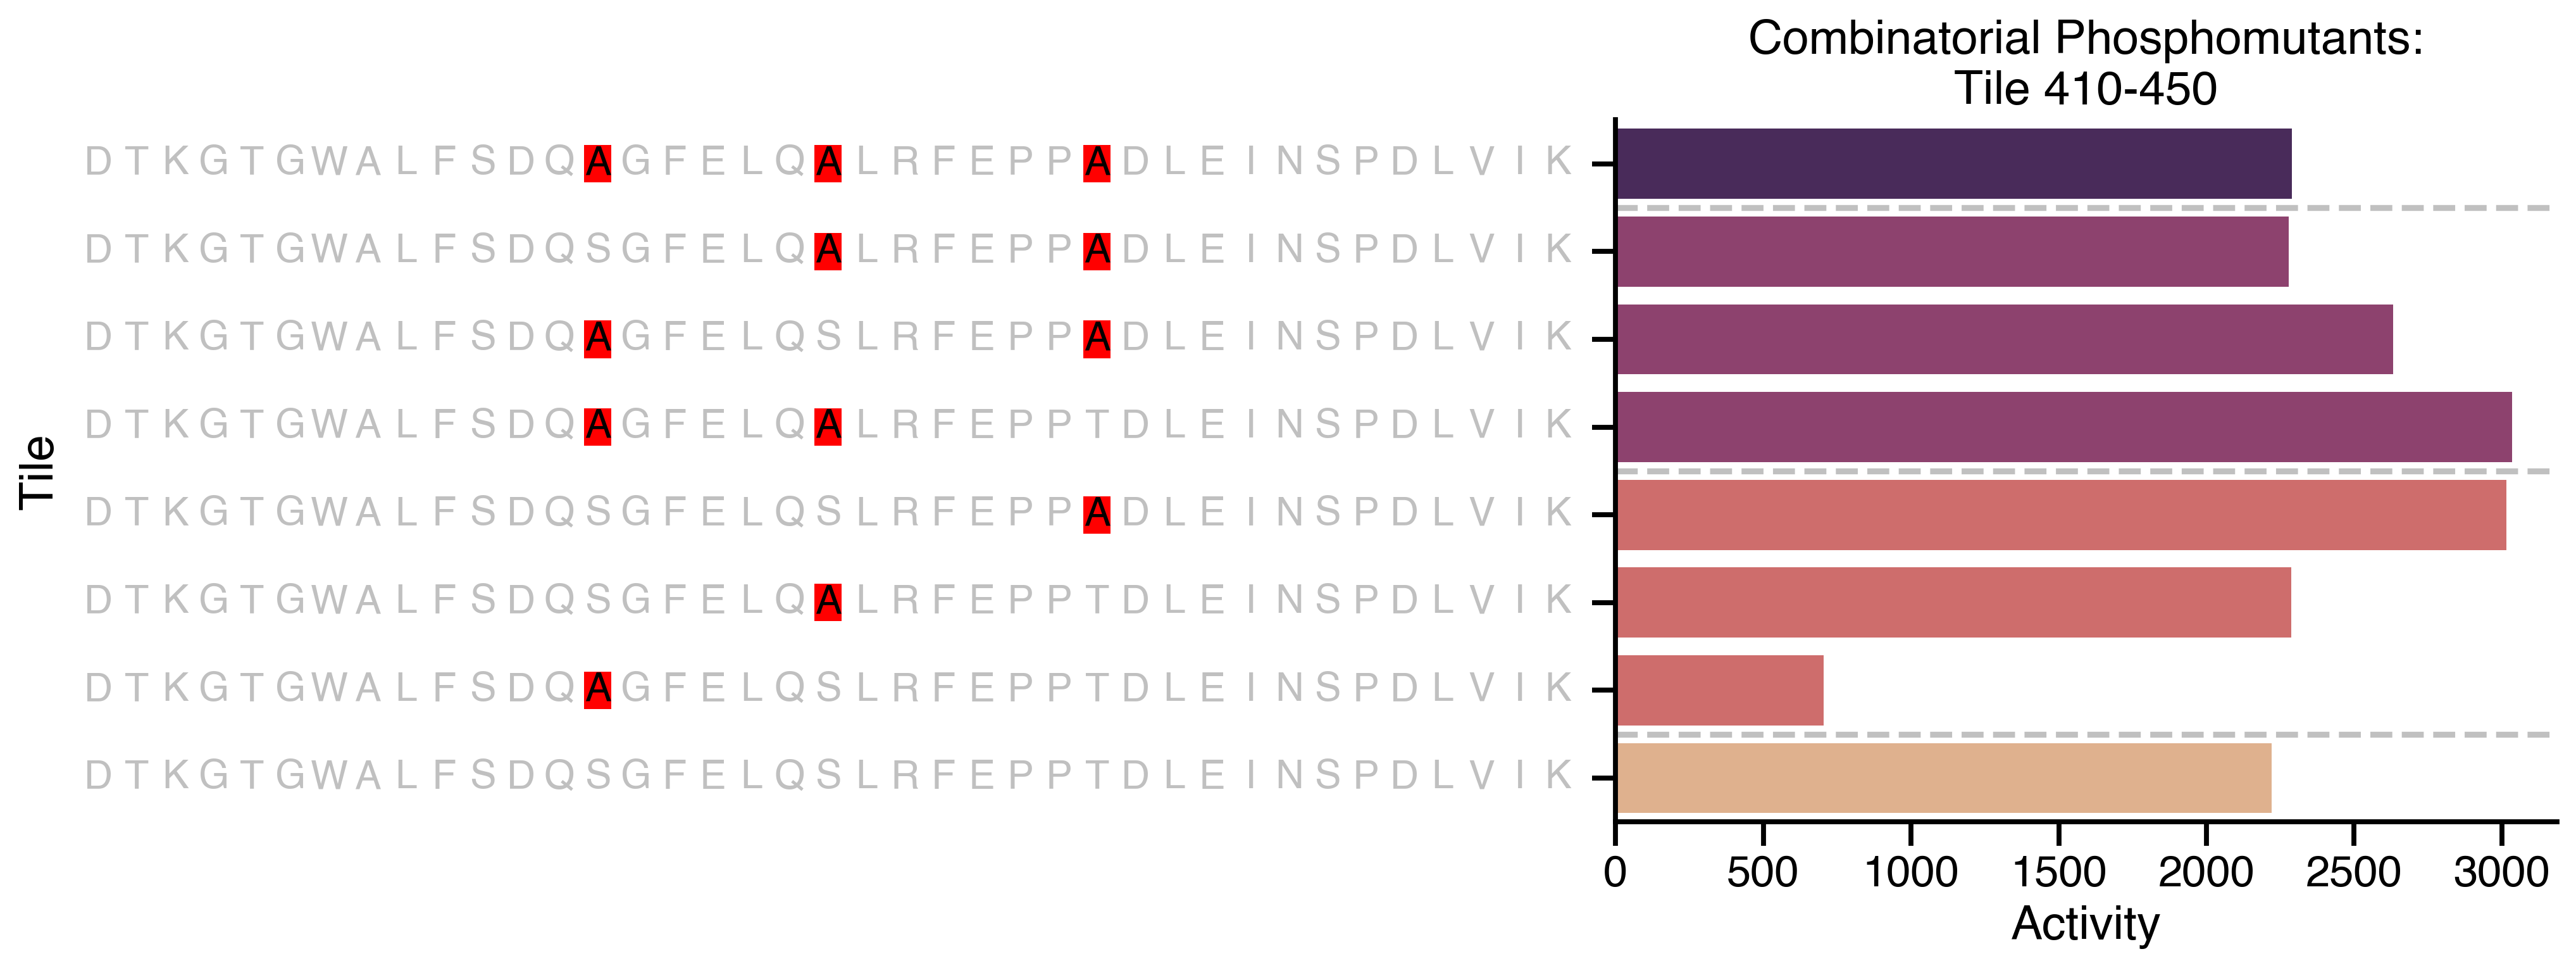

In [1268]:
plot_combination_activities(410, spacing = 130, title_spacing = 580)


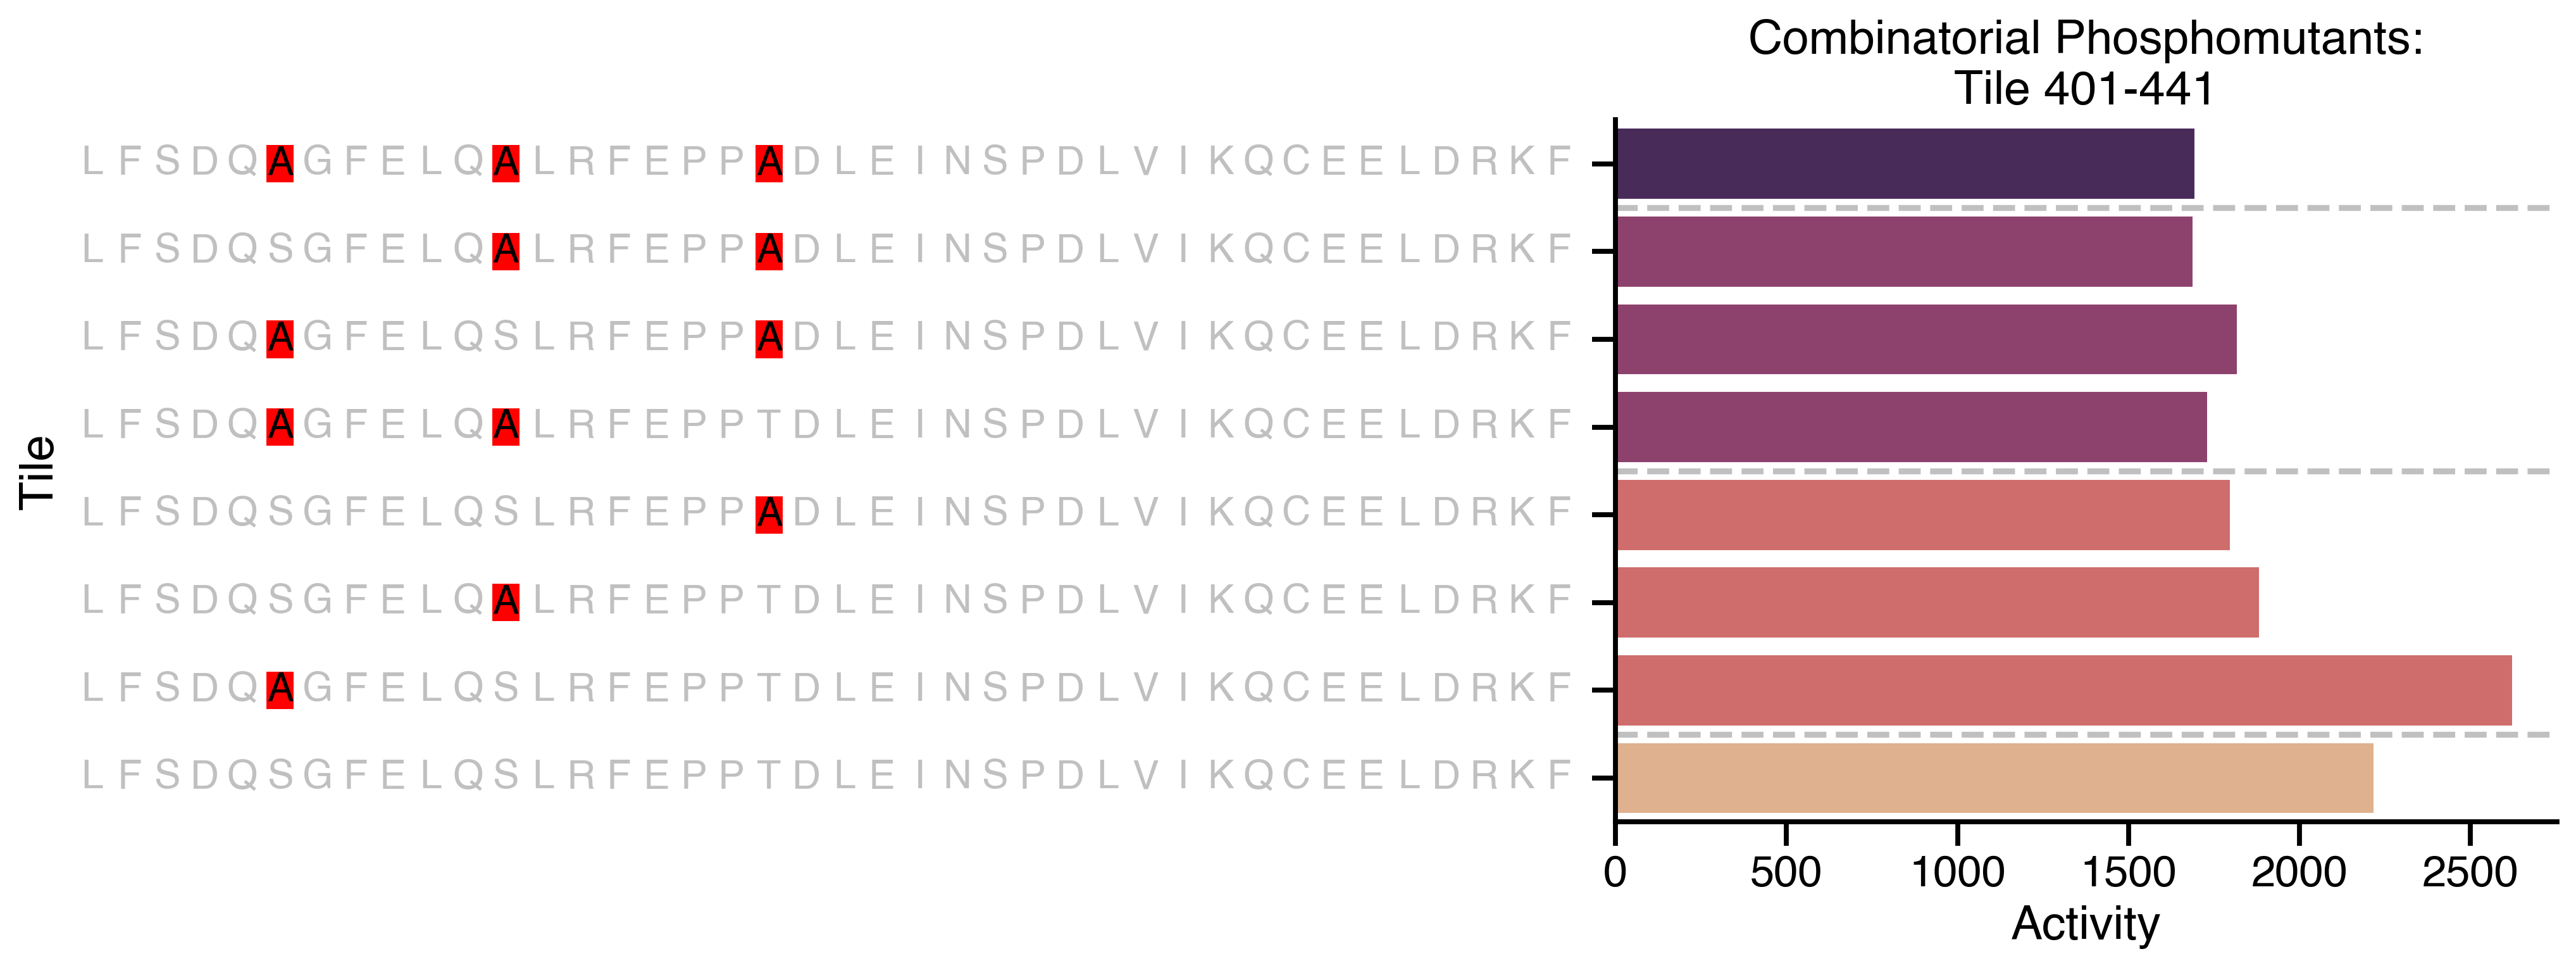

In [1270]:
plot_combination_activities(401, spacing = 110, title_spacing = 580)

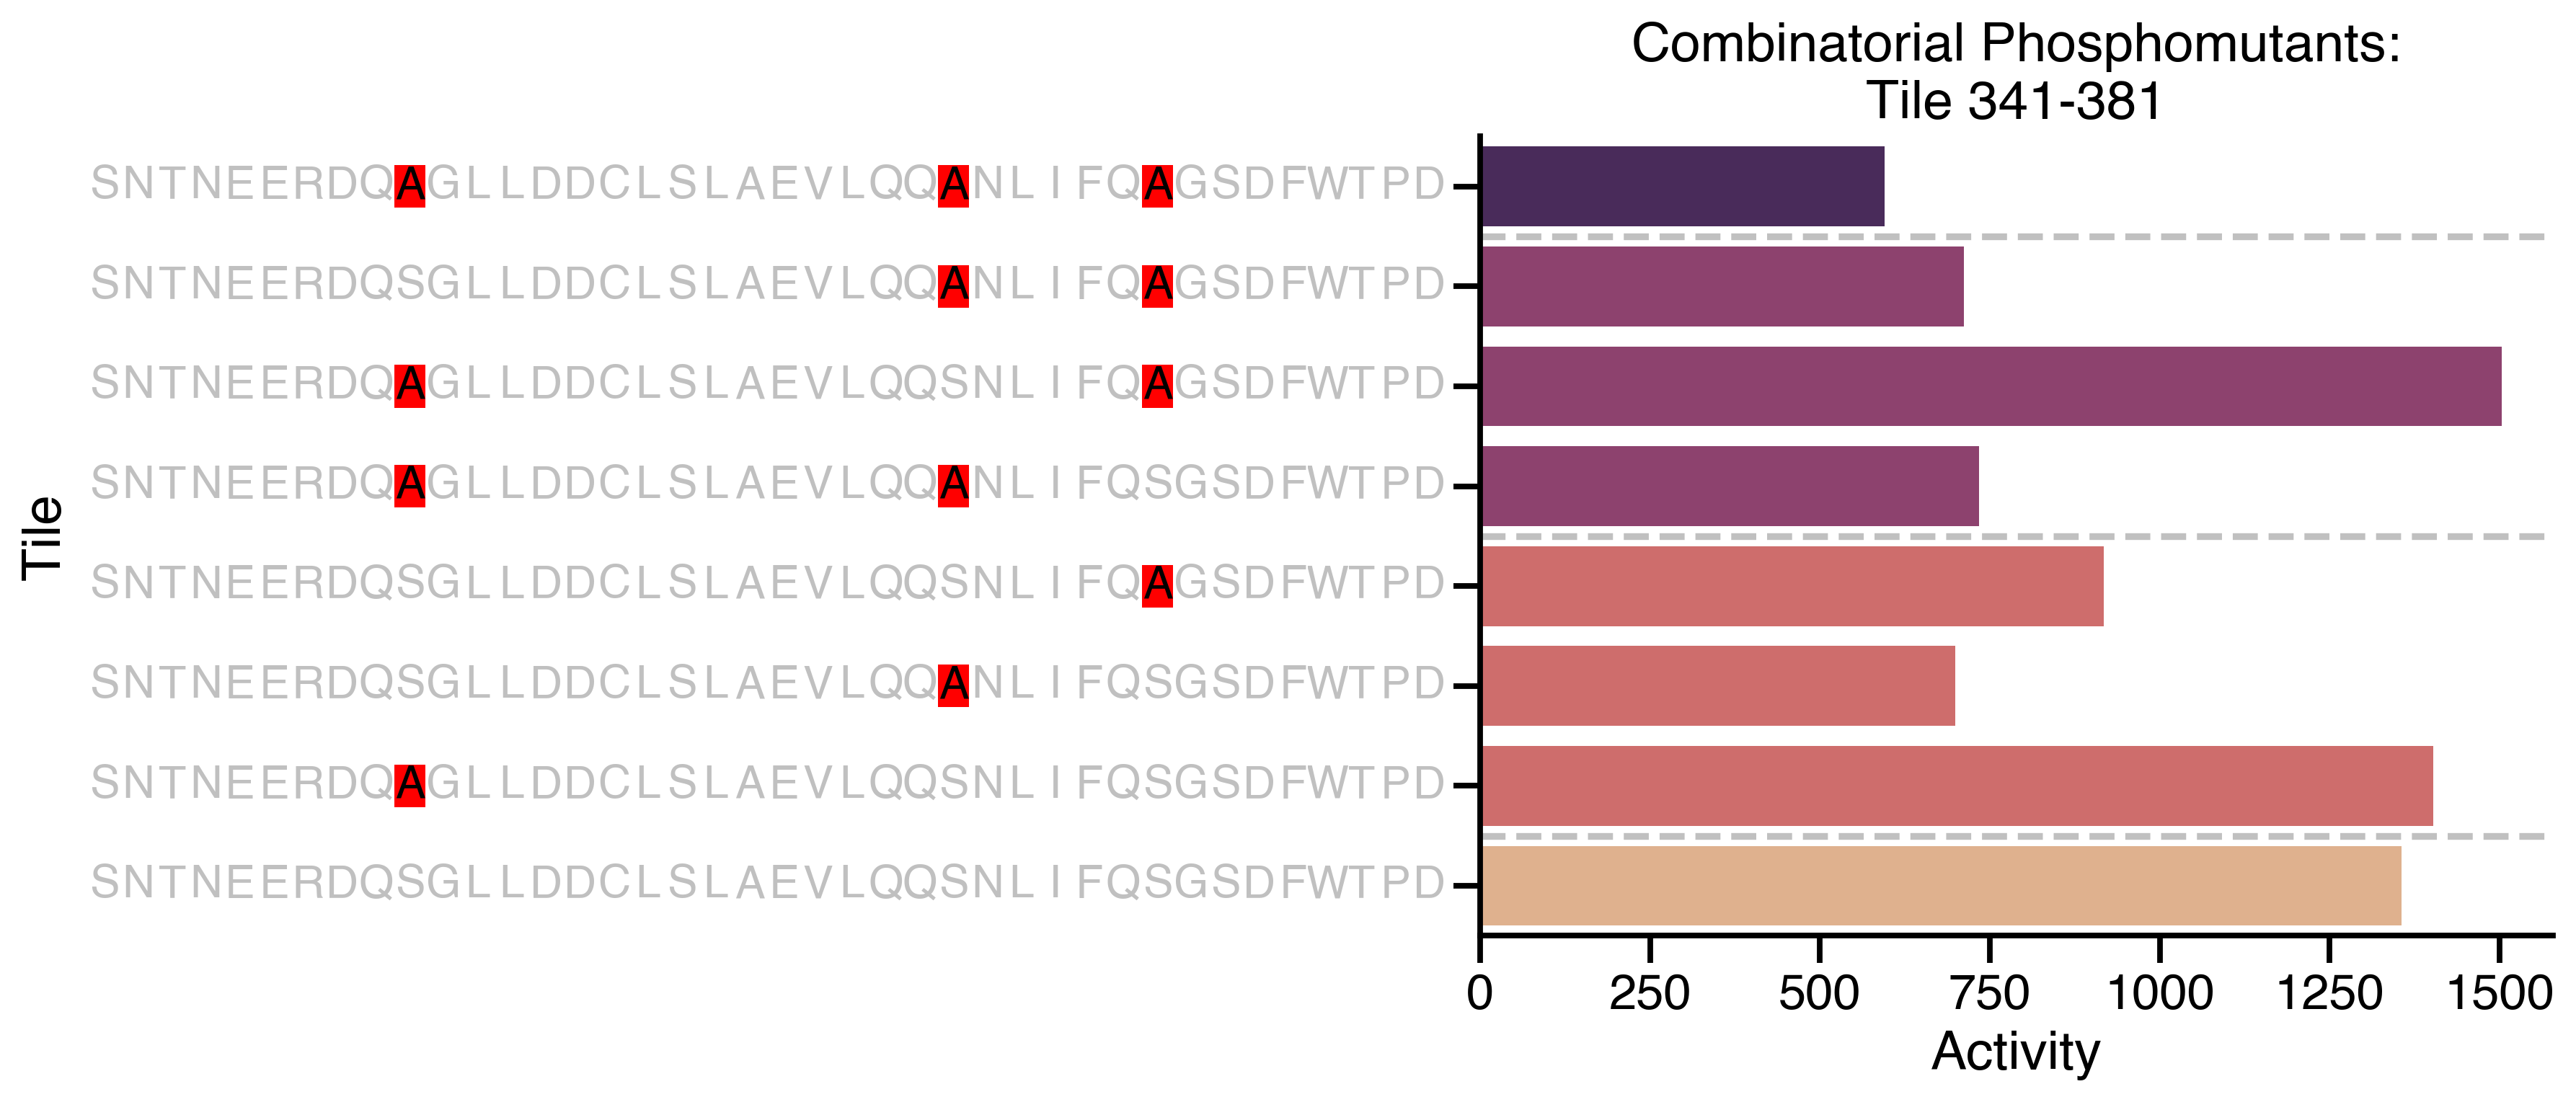

In [1257]:
plot_combination_activities(341, spacing = 50, title_spacing = 460)

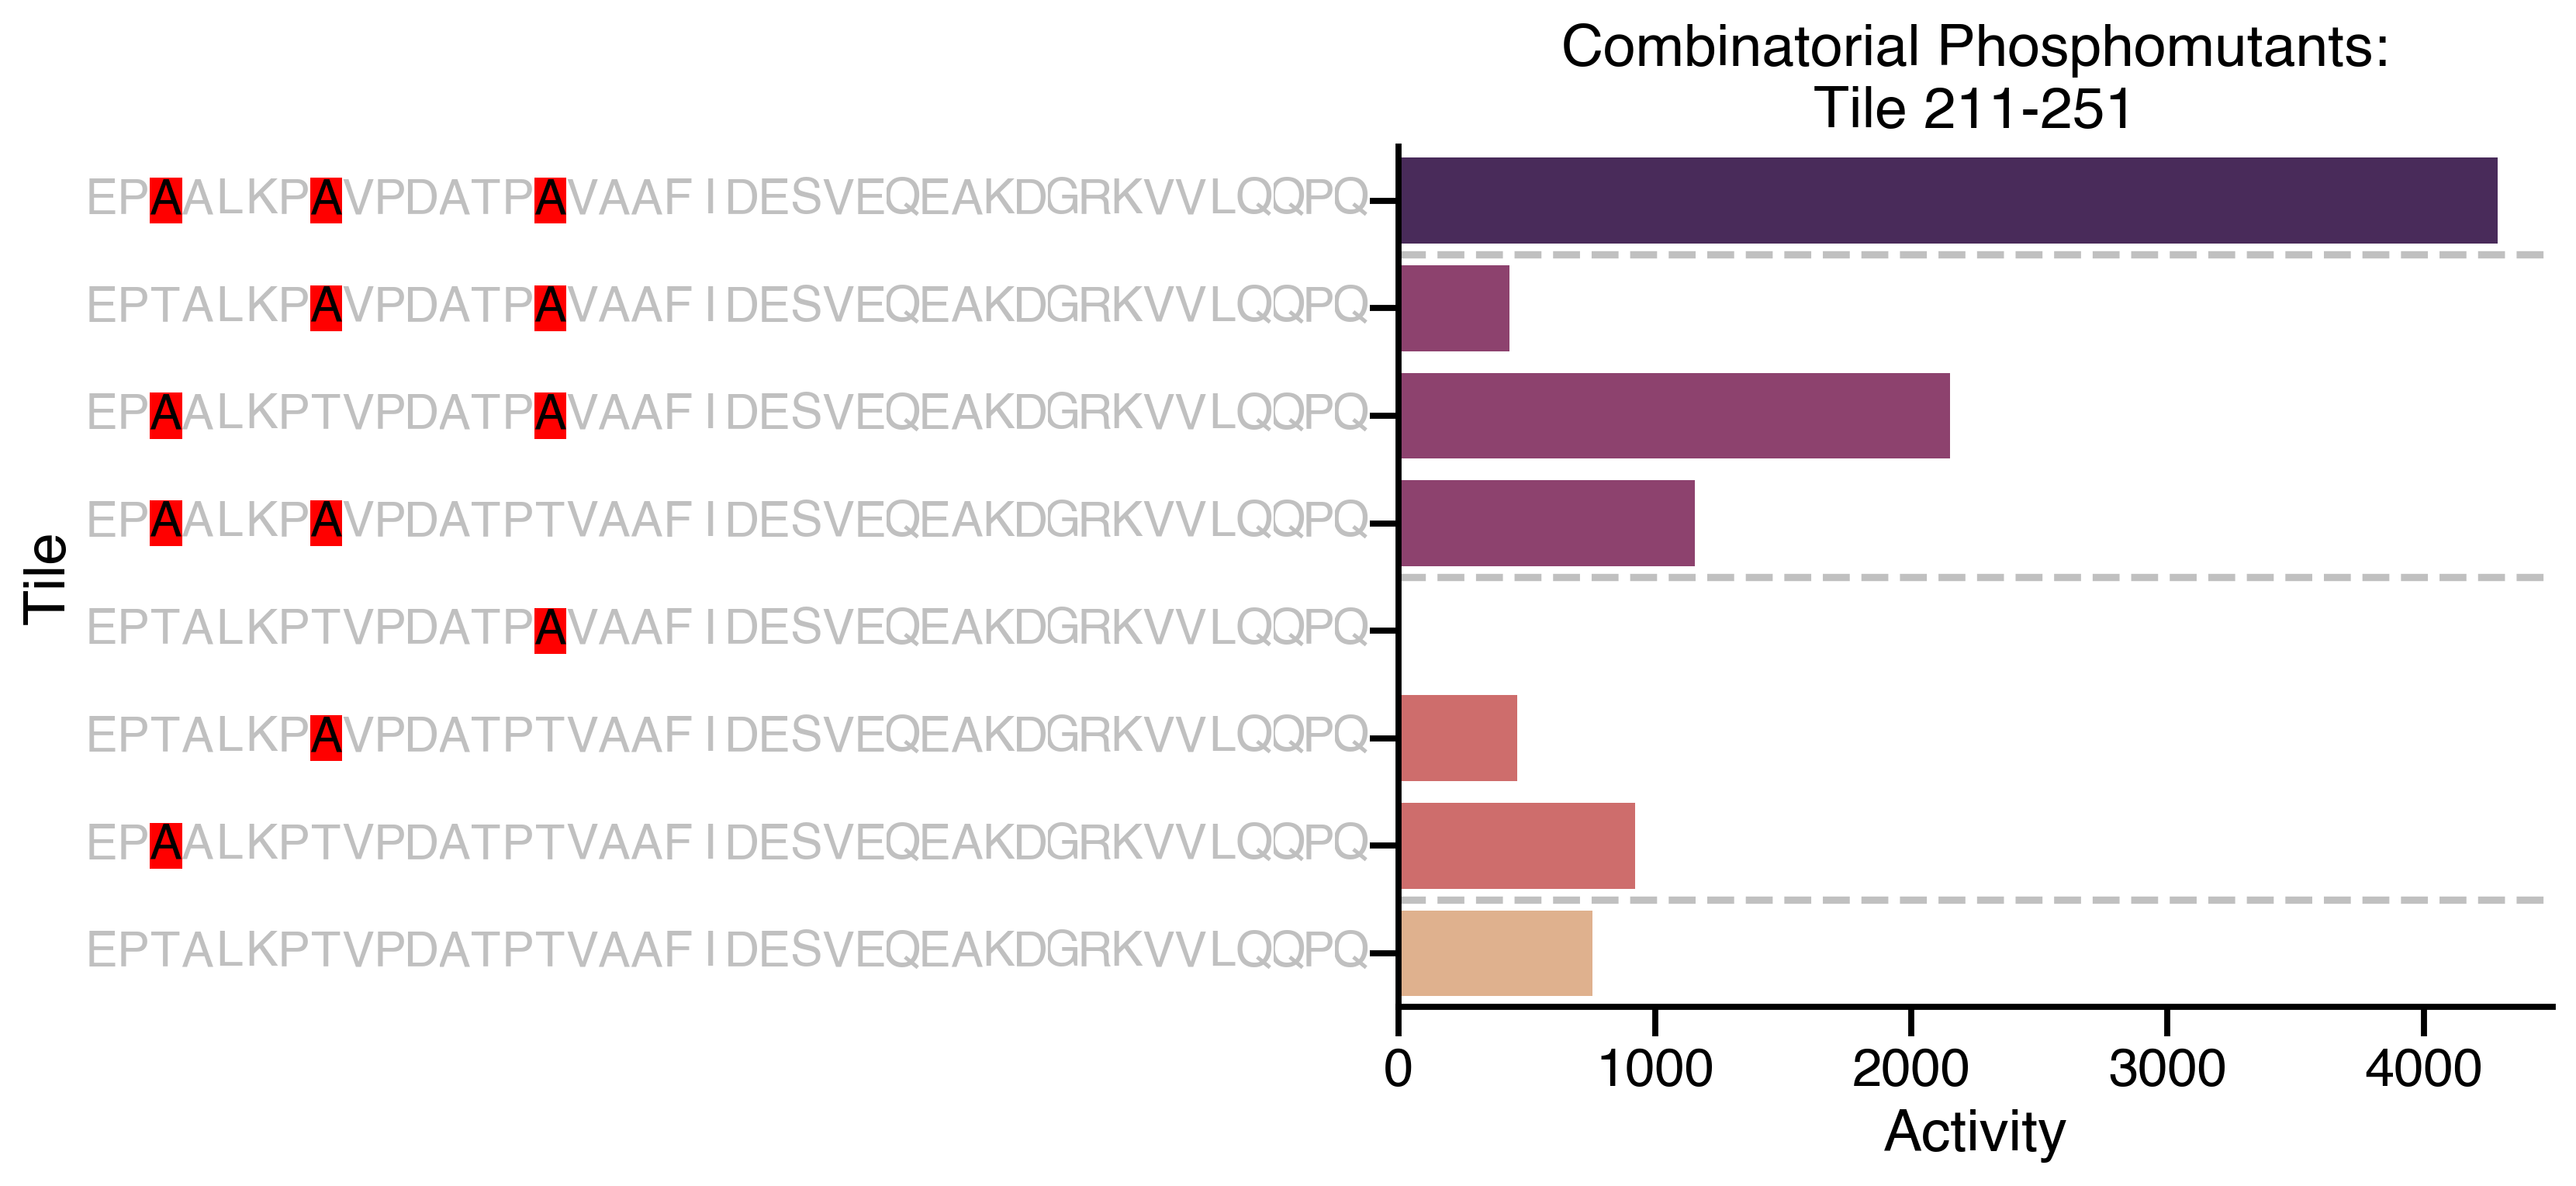

In [1258]:
plot_combination_activities(211, spacing = 125, title_spacing = 400)

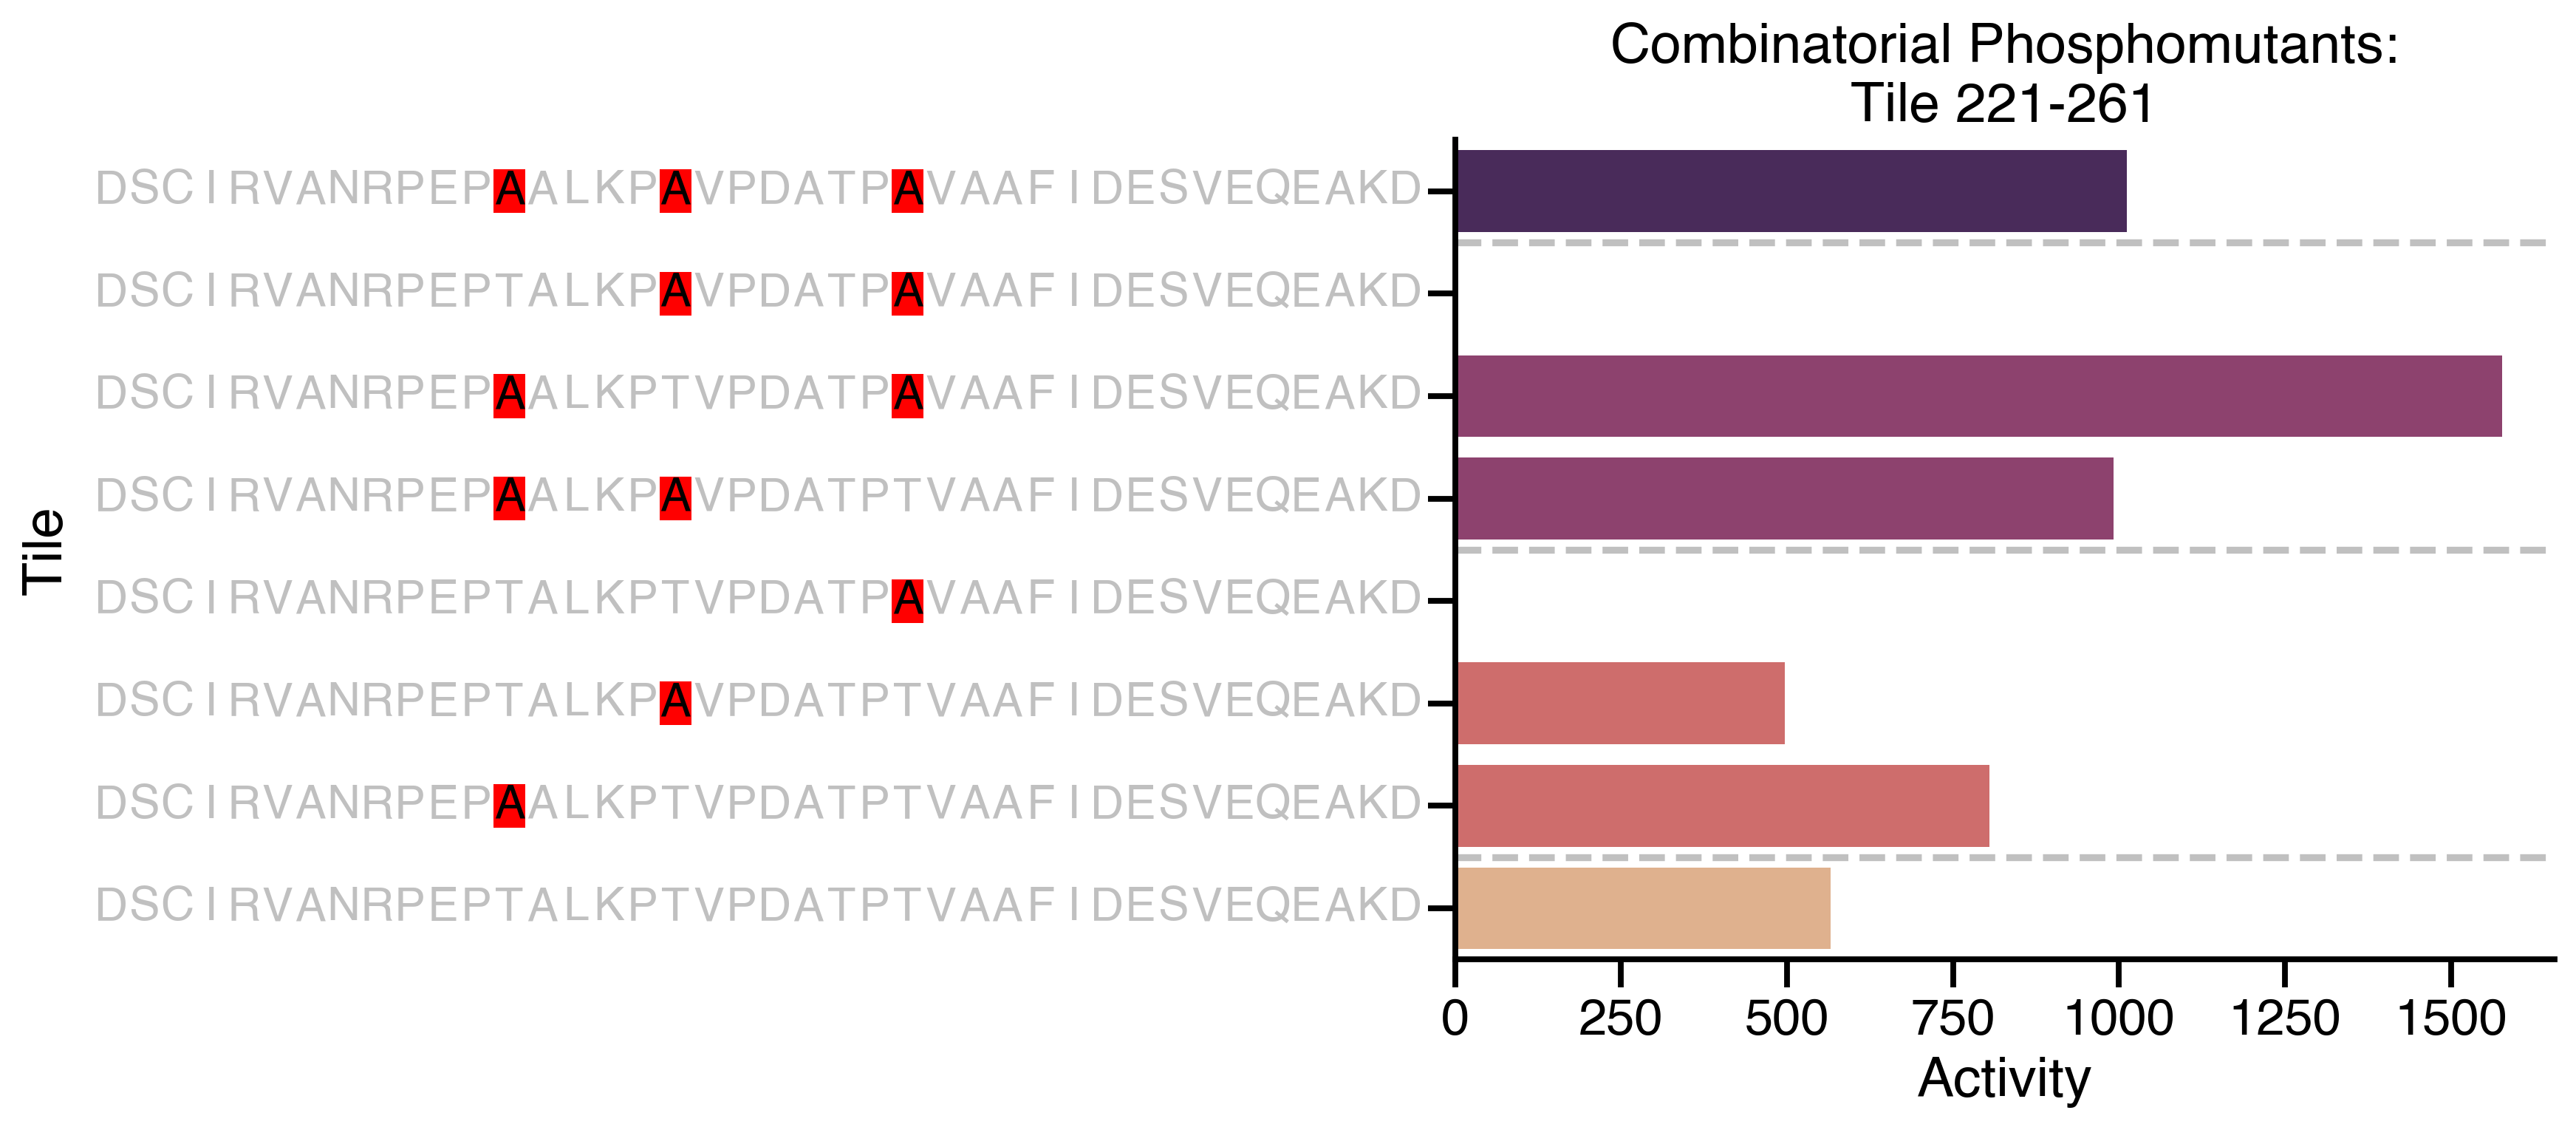

In [1259]:
plot_combination_activities(221, spacing = 50, title_spacing = 440)

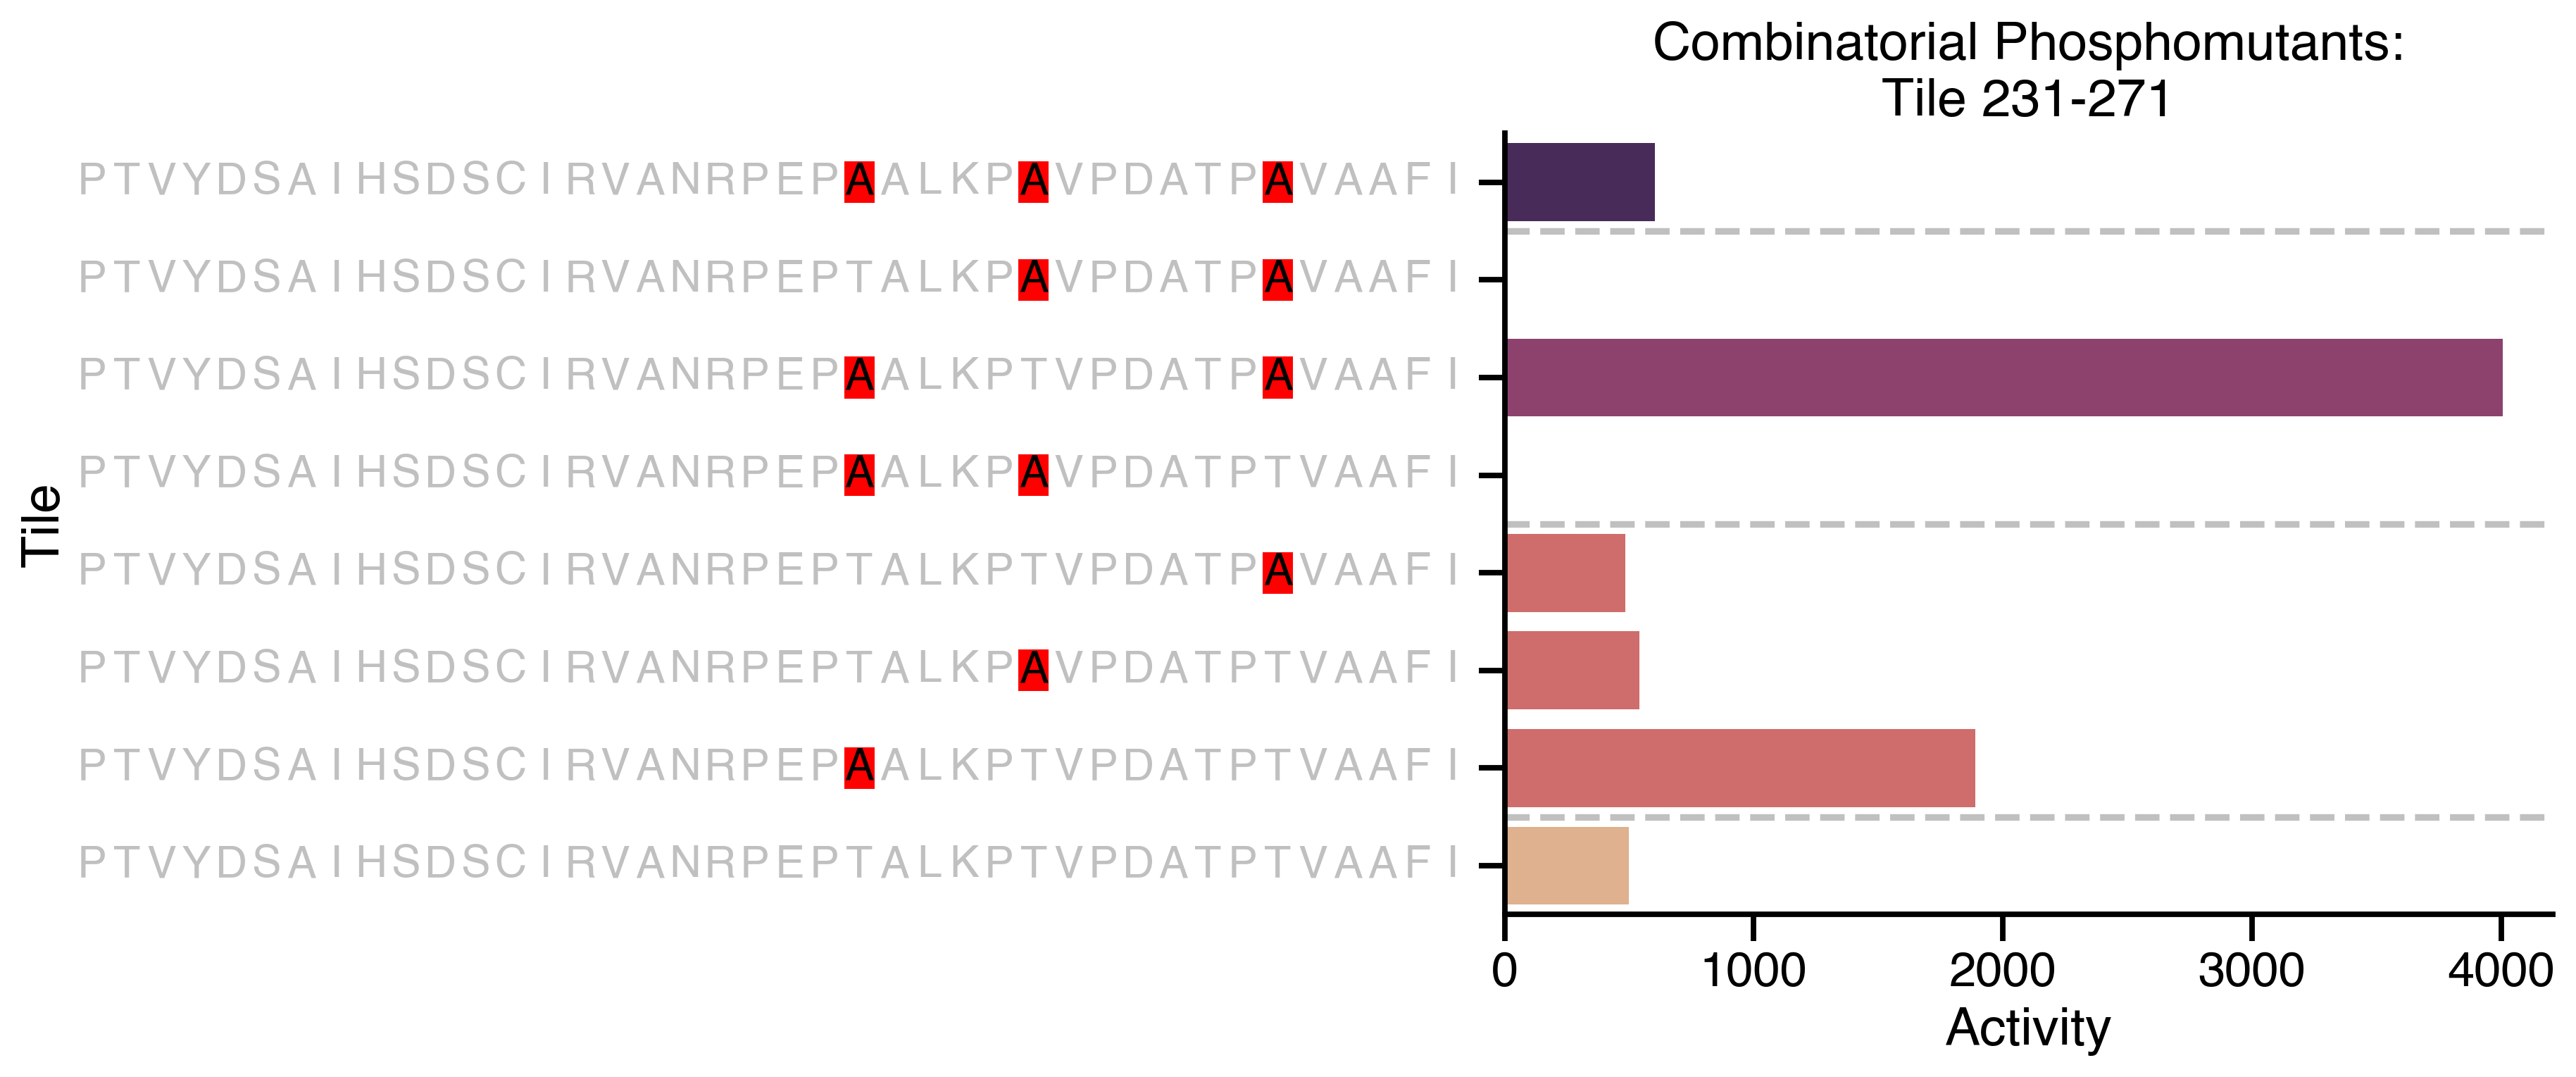

In [1260]:
plot_combination_activities(231, spacing = 140, title_spacing = 480)  

# 5. Does the presence/lack of the aromatic ring in the substituent (Ala versus Phe) alter the outcome? 

## 5.1 Scatter plot of A1a vs A2a


In [689]:
PSv_max2A_STYA = return_activities("PSv_max2A_STYA")
PSv_max2A_STYA.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,1_PSv_max2A_STYA,NaN,1,21,41,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,2221.077253,1949.884838,2085.481046
1,2_PSv_max2A_STYA,NaN,11,31,51,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,571.070293,561.121777,566.096035
2,3_PSv_max2A_STYA,NaN,21,41,61,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,767.843899,1303.514823,1035.679361


In [690]:
PSv_max2A_STYA = add_var_positions(PSv_max2A_STYA, BasicArTh, activity_col)
PSv_max2A_STYA.head(3)

,Description_var,Other_var,Start,mid,End,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,var,activ_diff,activ_fold_change
0,1_PSv_max2A_STYA,NaN,1,21,41,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,2221.077253,1949.884838,2085.481046,BasicArTh.1,Q6NQK2,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,349.798825,573.084946,461.441886,5,1871.278427,6.349585
1,2_PSv_max2A_STYA,NaN,11,31,51,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,571.070293,561.121777,566.096035,BasicArTh.2,Q6NQK2,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,470.700956,2417.845241,1444.273098,15,100.369337,1.213234
2,3_PSv_max2A_STYA,NaN,21,41,61,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,767.843899,1303.514823,1035.679361,BasicArTh.3,Q6NQK2,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,867.654700,1328.781736,1098.218218,21,-99.810800,0.884965


In [691]:
PSv_max2A_STAYF = return_activities("PSv_max2A_STAYF")
PSv_max2A_STAYF.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,1_PSv_max2A_STAYF,NaN,1,21,41,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,2221.077253,1949.884838,2085.481046
1,2_PSv_max2A_STAYF,NaN,11,31,51,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,571.070293,561.121777,566.096035
2,3_PSv_max2A_STAYF,NaN,21,41,61,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,767.843899,1303.514823,1035.679361


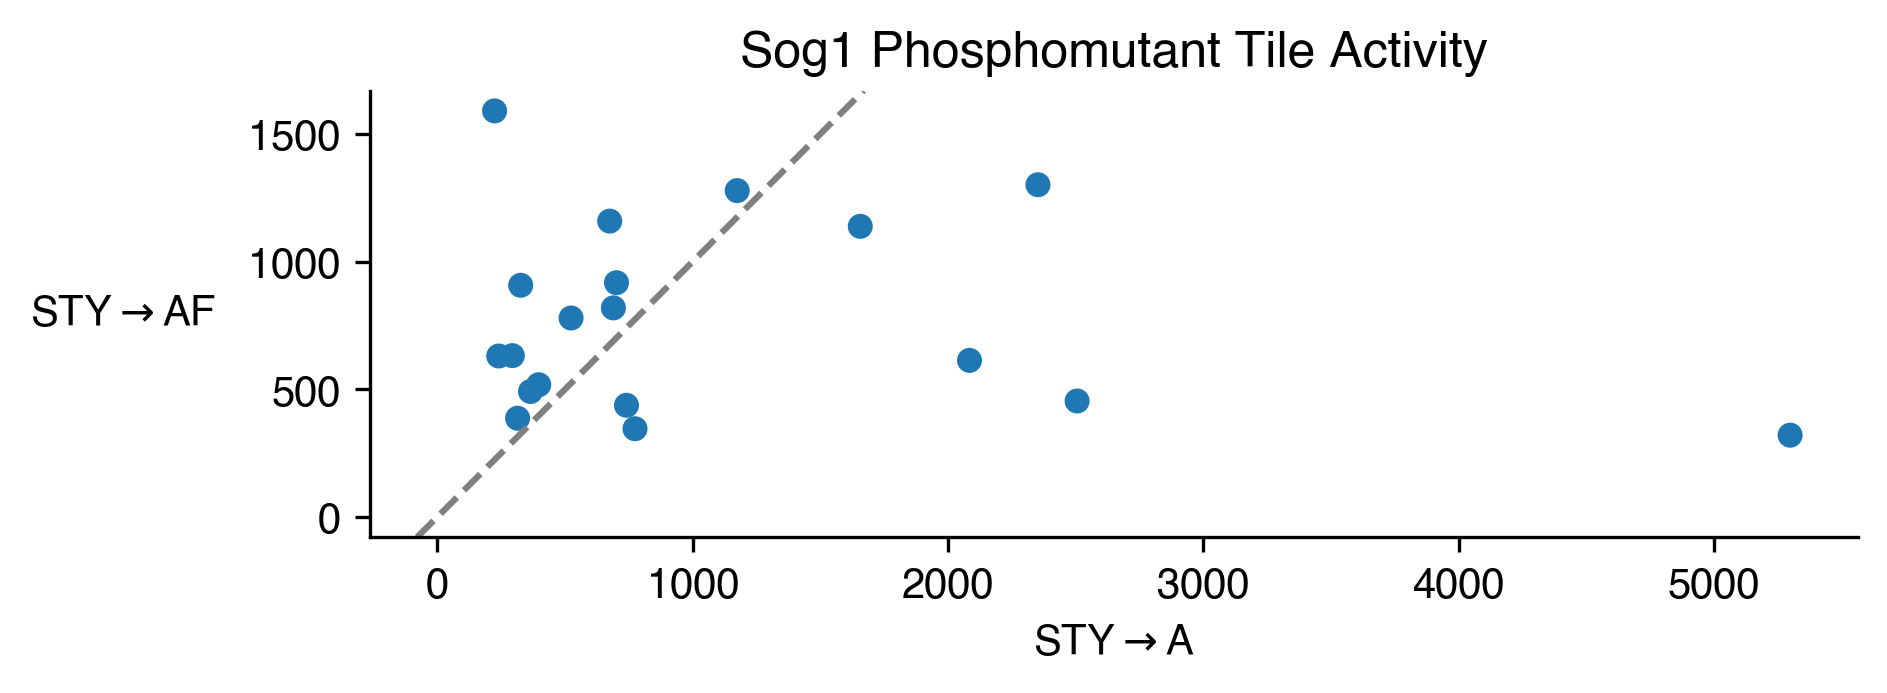

In [708]:
plt.figure(dpi = 300)
max_A_vs_F = pd.merge(PSv_max2A_STYA, PSv_max2A_STAYF, on = ["Start", "End", "mid"], suffixes = ("_A", "_AF")).dropna(subset = "Other")
sns.scatterplot(data = max_A_vs_F, x = activity_col + "_var", y = activity_col, edgecolor = 'none', alpha = 1)
plt.gca().set_aspect('equal')
plt.xlabel("STY$\\rightarrow$A")
plt.ylabel("STY$\\rightarrow$AF", rotation = 0, labelpad = 30, va = "center")
plt.title("Sog1 Phosphomutant Tile Activity")
plt.axline([0, 0], slope=1, color = "gray", linestyle = "--")
sns.despine()

## 5.2 Scatter plot of A1b vs A2b

In [707]:
PSv_pred2A_STYA = return_activities("PSv_pred2A_STYA")
PSv_pred2A_STYA.iloc[39]

Description                            40_PSv_pred2A_STYA
Other                                           PS:Y(!)x1
Start                                                 391
mid                                                   411
End                                                   431
tile             IADYAHLGPEDFKRDLEECQKIVLDPANIELDAPPEFRLA
Activity_S3_1                                  735.684127
Activity_S3_2                                  409.939704
lib2_avg                                       572.811915
Name: 39, dtype: object

In [703]:
PSv_pred2A_STAYF = return_activities("PSv_pred2A_STAYF")
PSv_pred2A_STAYF.head(3)

,Description,Other,Start,mid,End,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,1_PSv_pred2A_STAYF,NaN,1,21,41,MAGRSWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,280.882059,308.789199,294.835629
1,2_PSv_pred2A_STAYF,NaN,11,31,51,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNSD,316.923054,310.774205,313.848630
2,3_PSv_pred2A_STAYF,NaN,21,41,61,AAAADPRQVVWKANPARHCPKCQHVIDNSDVVDDWPGLPR,297.992003,309.075469,303.533736


In [704]:
pd.merge(PSv_pred2A_STYA,
                                PSv_pred2A_STAYF,
                                on = ["Start", "mid", "End"],
                               suffixes = ("_A", "_F"))

,Description_A,Other_A,Start,mid,End,tile_A,Activity_S3_1_A,Activity_S3_2_A,lib2_avg_A,Description_F,Other_F,tile_F,Activity_S3_1_F,Activity_S3_2_F,lib2_avg_F
0,1_PSv_pred2A_STYA,NaN,1,21,41,MAGRSWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,280.882059,308.789199,294.835629,1_PSv_pred2A_STAYF,NaN,MAGRSWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,280.882059,308.789199,294.835629
1,2_PSv_pred2A_STYA,NaN,11,31,51,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNSD,316.923054,310.774205,313.848630,2_PSv_pred2A_STAYF,NaN,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNSD,316.923054,310.774205,313.848630
2,3_PSv_pred2A_STYA,NaN,21,41,61,AAAADPRQVVWKANPARHCPKCQHVIDNSDVVDDWPGLPR,297.992003,309.075469,303.533736,3_PSv_pred2A_STAYF,NaN,AAAADPRQVVWKANPARHCPKCQHVIDNSDVVDDWPGLPR,297.992003,309.075469,303.533736
3,4_PSv_pred2A_STYA,NaN,31,51,71,WKANPARHCPKCQHVIDNSDVVDDWPGLPRGVKFDPADPE,402.366669,396.531998,399.449334,4_PSv_pred2A_STAYF,NaN,WKANPARHCPKCQHVIDNSDVVDDWPGLPRGVKFDPADPE,402.366669,396.531998,399.449334
4,5_PSv_pred2A_STYA,NaN,41,61,81,KCQHVIDNSDVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,320.632032,303.754013,312.193023,5_PSv_pred2A_STAYF,NaN,KCQHVIDNSDVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,320.632032,303.754013,312.193023
5,6_PSv_pred2A_STYA,NaN,51,71,91,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,2777.904051,2677.567887,2727.735969,6_PSv_pred2A_STAYF,NaN,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,2777.904051,2677.567887,2727.735969
6,7_PSv_pred2A_STYA,NaN,61,81,101,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,1278.976936,1243.423540,1261.200238,7_PSv_pred2A_STAYF,NaN,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,1278.976936,1243.423540,1261.200238
7,8_PSv_pred2A_STYA,PS:Y(!)x1,71,91,111,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICYAHPKN,2365.051074,2792.482867,2578.766970,8_PSv_pred2A_STAYF,PS:Y(!)x1,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICYAHPKN,2365.051074,2792.482867,2578.766970
8,9_PSv_pred2A_STYA,PS:Y(!)x1,81,101,121,LAGLAAHPFIDEFIPAVNQDDGICYAHPKNLPGVKADGTV,610.609357,570.076927,590.343142,9_PSv_pred2A_STAYF,PS:Y(!)x1,LAGLAAHPFIDEFIPAVNQDDGICYAHPKNLPGVKADGTV,610.609357,570.076927,590.343142
9,10_PSv_pred2A_STYA,PS:Y(!)x1,91,111,131,DEFIPAVNQDDGICYAHPKNLPGVKADGTVAHFFHKAIKA,618.169787,829.155814,723.662801,10_PSv_pred2A_STAYF,PS:Y(!)x1,DEFIPAVNQDDGICYAHPKNLPGVKADGTVAHFFHKAIKA,618.169787,829.155814,723.662801


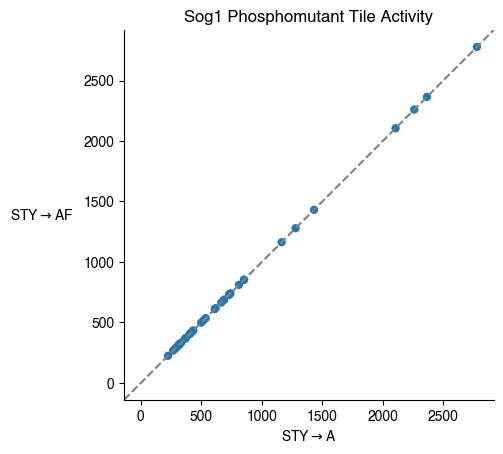

In [705]:
sns.scatterplot(data = pd.merge(PSv_pred2A_STYA,
                                PSv_pred2A_STAYF,
                                on = ["Start", "mid", "End"],
                               suffixes = ("_A", "_F")), 
                x = activity_col + "_A", y = activity_col + "_F", edgecolor = 'none', alpha = 1)
plt.gca().set_aspect('equal')
plt.xlabel("STY$\\rightarrow$A")
plt.ylabel("STY$\\rightarrow$AF", rotation = 0, labelpad = 30, va = "center")
plt.title("Sog1 Phosphomutant Tile Activity")
plt.axline([0, 0], slope=1, color = "gray", linestyle = "--")
sns.despine()
# Seems like there's a mistake with the library sequences? look identical to me...

# Full phosphomutant vs phosphomimetics

In [125]:
# Confirmed --> A|
PSv_conf2fA_STYA = return_activities("PSv_conf2fA_STYA")
PSv_conf2fA_STYA.head(3)

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2fA_STYA,NaN,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,589.233964,567.661610,578.447787
1,8_PSv_conf2fA_STYA,NaN,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,2073.520699,2127.003654,2100.262176
2,9_PSv_conf2fA_STYA,NaN,81,101,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,1469.859938,1112.678850,1291.269394


In [126]:
# WT tiles
BasicArTh = return_activities("BasicArTh", pos_regex = r'\.(\d+)')
BasicArTh.head(3)

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,BasicArTh.1,Q6NQK2,1,21,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,1407.799127,1244.615820,1326.207474
1,BasicArTh.2,Q6NQK2,11,31,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,4479.018364,3954.541874,4216.780119
2,BasicArTh.3,Q6NQK2,21,41,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,1434.266772,1013.665108,1223.965940


In [127]:
# confirmed -> D
PSv_conf2fD = return_activities("PSv_conf2fD")
PSv_conf2fD = PSv_conf2fD[~PSv_conf2fD["Description"].str.contains("DD")]
PSv_conf2fD.head(3)

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2fD,/,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPDVNQD,612.310337,525.559638,568.934988
1,8_PSv_conf2fD,/,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPDVNQDDGICYTHPKN,1330.105073,964.886411,1147.495742
2,9_PSv_conf2fD,/,81,101,LSGLSSHPFIDEFIPDVNQDDGICYTHPKNLPGVKSDGTV,3366.486424,3734.635082,3550.560753


In [128]:
# confirmed -> E
PSv_conf2fE = return_activities("PSv_conf2fE")
PSv_conf2fE = PSv_conf2fE[~PSv_conf2fE["Description"].str.contains("EE")]
PSv_conf2fE.head(3)

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2fE,/,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPEVNQD,1196.413506,1294.538370,1245.475938
1,8_PSv_conf2fE,/,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPEVNQDDGICYTHPKN,333.031253,320.143346,326.587300
2,9_PSv_conf2fE,/,81,101,LSGLSSHPFIDEFIPEVNQDDGICYTHPKNLPGVKSDGTV,5679.765438,1525.343149,3602.554294


In [129]:
sns.color_palette('Dark2')

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [130]:
BasicArTh

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,BasicArTh.1,Q6NQK2,1,21,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,1407.799127,1244.615820,1326.207474
1,BasicArTh.2,Q6NQK2,11,31,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,4479.018364,3954.541874,4216.780119
2,BasicArTh.3,Q6NQK2,21,41,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,1434.266772,1013.665108,1223.965940
3,BasicArTh.4,Q6NQK2,31,51,WKSNPSRHCPKCQHVIDNSDVVDDWPGLPRGVKFDPSDPE,3815.896461,3782.725600,3799.311031
4,BasicArTh.5,Q6NQK2,41,61,KCQHVIDNSDVVDDWPGLPRGVKFDPSDPEIIWHLLAKSG,538.931880,933.900949,736.416415
5,BasicArTh.6,Q6NQK2,51,71,VVDDWPGLPRGVKFDPSDPEIIWHLLAKSGLSGLSSHPFI,1379.276161,1392.248129,1385.762145
6,BasicArTh.7,Q6NQK2,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,640.499185,1517.695164,1079.097175
7,BasicArTh.8,Q6NQK2,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,444.761592,369.638636,407.200114
8,BasicArTh.9,Q6NQK2,81,101,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,3635.249963,1403.352788,2519.301376
9,BasicArTh.10,Q6NQK2,91,111,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,1974.901465,1577.686428,1776.293946


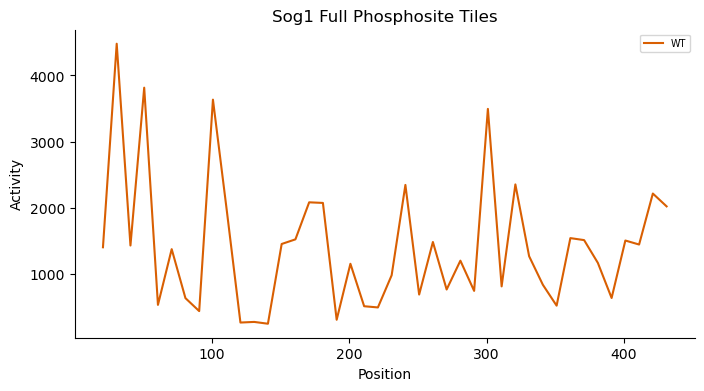

In [131]:
plt.figure(figsize = (8, 4))
plt.title("Sog1 Full Phosphosite Tiles")
# sns.lineplot(data = PSv_conf2fD, x = "mid", y = "Activity_S3_1", label = "Phosphomimetic (→ D)", 
#              color = sns.color_palette('Dark2')[0])
# sns.lineplot(data = PSv_conf2fE, x = "mid", y = "Activity_S3_1", label = "Phosphomimetic (→ E)", 
#              color = sns.color_palette('Dark2')[4])
# sns.lineplot(data = PSv_conf2fA_STYA, x = "mid", y = "Activity_S3_1", label = "Phosphomutant (→ A)",
#             color = sns.color_palette('Dark2')[2])
sns.lineplot(data = BasicArTh, x = "mid", y = "Activity_S3_1", label = "WT",
            color = sns.color_palette('Dark2')[1])
plt.ylabel("Activity")
plt.xlabel("Position")
plt.legend(fontsize = 'x-small')
sns.despine()

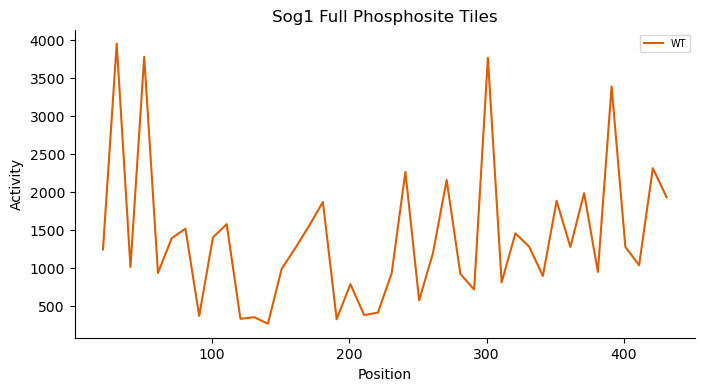

In [111]:
plt.figure(figsize = (8, 4))
plt.title("Sog1 Full Phosphosite Tiles")
# sns.lineplot(data = PSv_conf2fD, x = "mid", y = "Activity_S3_1", label = "Phosphomimetic (→ D)", 
#              color = sns.color_palette('Dark2')[0])
# sns.lineplot(data = PSv_conf2fE, x = "mid", y = "Activity_S3_1", label = "Phosphomimetic (→ E)", 
#              color = sns.color_palette('Dark2')[4])
# sns.lineplot(data = PSv_conf2fA_STYA, x = "mid", y = "Activity_S3_1", label = "Phosphomutant (→ A)",
#             color = sns.color_palette('Dark2')[2])
sns.lineplot(data = BasicArTh, x = "mid", y = "Activity_S3_1", label = "WT",
            color = sns.color_palette('Dark2')[1])
plt.ylabel("Activity")
plt.xlabel("Position")
plt.legend(fontsize = 'x-small')
sns.despine()

# Single confirmed phosphomutants

In [92]:
# Confirmed --> A|
PSv_conf2sA_STYA = return_activities("PSv_conf2sA_STYA")
PSv_conf2sA_STYA.head(3)

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,7_PSv_conf2sA_STYA,NaN,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,1092.60882,936.680201,1014.644511
1,8_PSv_conf2sA_STYA,NaN,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,NaN,NaN
2,9_PSv_conf2sA_STYA,NaN,81,101,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,NaN,NaN,NaN


In [93]:
BasicArTh

,Description,Other,Start,mid,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,BasicArTh.1,Q6NQK2,1,21,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,325.589741,1145.485487,735.537614
1,BasicArTh.2,Q6NQK2,11,31,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,486.291472,994.210803,740.251137
2,BasicArTh.3,Q6NQK2,21,41,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,451.592854,1274.866012,863.229433
3,BasicArTh.4,Q6NQK2,31,51,WKSNPSRHCPKCQHVIDNSDVVDDWPGLPRGVKFDPSDPE,531.962017,1276.959257,904.460637
4,BasicArTh.5,Q6NQK2,41,61,KCQHVIDNSDVVDDWPGLPRGVKFDPSDPEIIWHLLAKSG,645.730956,1627.560299,1136.645628
5,BasicArTh.6,Q6NQK2,51,71,VVDDWPGLPRGVKFDPSDPEIIWHLLAKSGLSGLSSHPFI,1514.219587,1407.624185,1460.921886
6,BasicArTh.7,Q6NQK2,61,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1220.993347,1403.427453,1312.210400
7,BasicArTh.8,Q6NQK2,71,91,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,453.061076,344.727272,398.894174
8,BasicArTh.9,Q6NQK2,81,101,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,675.177199,549.058501,612.117850
9,BasicArTh.10,Q6NQK2,91,111,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,446.256573,1046.894906,746.575739


In [94]:
conf2sA_STYA_vs_basic = pd.merge(PSv_conf2sA_STYA, BasicArTh, on = "mid", suffixes = ("_var", "_wt"), how = "right")
conf2sA_STYA_vs_basic

,Description_var,Other_var,Start_var,mid,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,Start_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt
0,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,BasicArTh.1,Q6NQK2,1,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,325.589741,1145.485487,735.537614
1,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,BasicArTh.2,Q6NQK2,11,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,486.291472,994.210803,740.251137
2,NaN,NaN,NaN,41,NaN,NaN,NaN,NaN,BasicArTh.3,Q6NQK2,21,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,451.592854,1274.866012,863.229433
3,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,BasicArTh.4,Q6NQK2,31,WKSNPSRHCPKCQHVIDNSDVVDDWPGLPRGVKFDPSDPE,531.962017,1276.959257,904.460637
4,NaN,NaN,NaN,61,NaN,NaN,NaN,NaN,BasicArTh.5,Q6NQK2,41,KCQHVIDNSDVVDDWPGLPRGVKFDPSDPEIIWHLLAKSG,645.730956,1627.560299,1136.645628
5,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,BasicArTh.6,Q6NQK2,51,VVDDWPGLPRGVKFDPSDPEIIWHLLAKSGLSGLSSHPFI,1514.219587,1407.624185,1460.921886
6,7_PSv_conf2sA_STYA,NaN,61.0,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,1092.608820,936.680201,1014.644511,BasicArTh.7,Q6NQK2,61,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1220.993347,1403.427453,1312.210400
7,8_PSv_conf2sA_STYA,NaN,71.0,91,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,NaN,NaN,BasicArTh.8,Q6NQK2,71,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,453.061076,344.727272,398.894174
8,9_PSv_conf2sA_STYA,NaN,81.0,101,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,NaN,NaN,NaN,BasicArTh.9,Q6NQK2,81,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,675.177199,549.058501,612.117850
9,10_PSv_conf2sA_STYA,NaN,91.0,111,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,NaN,NaN,BasicArTh.10,Q6NQK2,91,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,446.256573,1046.894906,746.575739


In [95]:
def find_difference_index(str1, str2):
    if type(str1) != str or type(str2) != str:
        return None
    # Iterate over the characters of the strings and find the index where they differ
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return i
    # If the strings are identical until the shortest length, return the length of the shortest string
    if len(str1) != len(str2):
        return min(len(str1), len(str2))
    return None  # Return None if the strings are identical

# Apply this function to each row in the DataFrame
diffs = []
for i in conf2sA_STYA_vs_basic.index:
    diffs.append(find_difference_index(conf2sA_STYA_vs_basic['tile_var'].iloc[i], 
                                       conf2sA_STYA_vs_basic['tile_wt'].iloc[i]))
conf2sA_STYA_vs_basic["var"] = diffs
conf2sA_STYA_vs_basic["var"] = conf2sA_STYA_vs_basic["var"] + conf2sA_STYA_vs_basic["Start_var"]
conf2sA_STYA_vs_basic["activ_change"] = conf2sA_STYA_vs_basic["Activity_S3_1_var"] - conf2sA_STYA_vs_basic["Activity_S3_1_wt"]
conf2sA_STYA_vs_basic

,Description_var,Other_var,Start_var,mid,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,Start_wt,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,lib2_avg_wt,var,activ_change
0,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,BasicArTh.1,Q6NQK2,1,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,325.589741,1145.485487,735.537614,NaN,NaN
1,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,BasicArTh.2,Q6NQK2,11,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,486.291472,994.210803,740.251137,NaN,NaN
2,NaN,NaN,NaN,41,NaN,NaN,NaN,NaN,BasicArTh.3,Q6NQK2,21,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,451.592854,1274.866012,863.229433,NaN,NaN
3,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,BasicArTh.4,Q6NQK2,31,WKSNPSRHCPKCQHVIDNSDVVDDWPGLPRGVKFDPSDPE,531.962017,1276.959257,904.460637,NaN,NaN
4,NaN,NaN,NaN,61,NaN,NaN,NaN,NaN,BasicArTh.5,Q6NQK2,41,KCQHVIDNSDVVDDWPGLPRGVKFDPSDPEIIWHLLAKSG,645.730956,1627.560299,1136.645628,NaN,NaN
5,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,BasicArTh.6,Q6NQK2,51,VVDDWPGLPRGVKFDPSDPEIIWHLLAKSGLSGLSSHPFI,1514.219587,1407.624185,1460.921886,NaN,NaN
6,7_PSv_conf2sA_STYA,NaN,61.0,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,1092.608820,936.680201,1014.644511,BasicArTh.7,Q6NQK2,61,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,1220.993347,1403.427453,1312.210400,96.0,-128.384528
7,8_PSv_conf2sA_STYA,NaN,71.0,91,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,NaN,NaN,BasicArTh.8,Q6NQK2,71,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,453.061076,344.727272,398.894174,96.0,NaN
8,9_PSv_conf2sA_STYA,NaN,81.0,101,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,NaN,NaN,NaN,BasicArTh.9,Q6NQK2,81,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,675.177199,549.058501,612.117850,96.0,NaN
9,10_PSv_conf2sA_STYA,NaN,91.0,111,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,NaN,NaN,BasicArTh.10,Q6NQK2,91,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,446.256573,1046.894906,746.575739,96.0,NaN


In [96]:
set(conf2sA_STYA_vs_basic["var"])

{nan,
 nan,
 nan,
 nan,
 nan,
 237.0,
 244.0,
 249.0,
 356.0,
 423.0,
 424.0,
 nan,
 nan,
 nan,
 372.0,
 430.0,
 nan,
 431.0,
 436.0,
 437.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 96.0,
 350.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan}

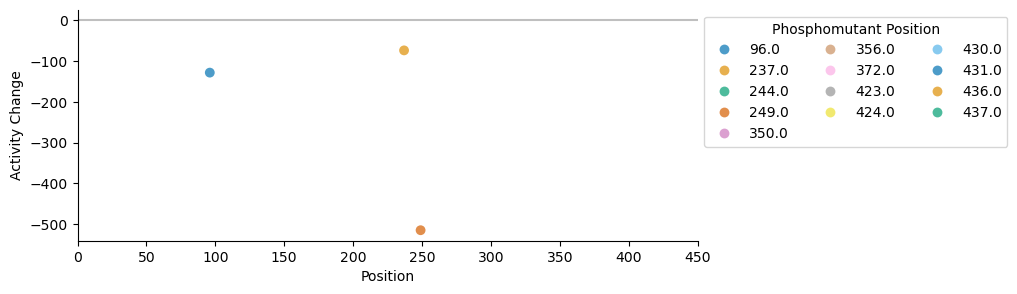

In [97]:
plt.figure(figsize = (8, 3))
plt.axhline(0, color = "gray", alpha = 0.5)
sns.scatterplot(data = conf2sA_STYA_vs_basic, x = "var", y = "activ_change", 
                edgecolor = 'none', alpha = 0.7, s = 50, hue = "var", 
                palette = "colorblind")
plt.legend(bbox_to_anchor = (1, 1), title = "Phosphomutant Position", ncol = 3)
plt.xlabel("Position")
plt.ylabel("Activity Change")
plt.xlim(0, 450)
sns.despine()

In [98]:
# plt.figure(figsize = (8, 3))
# sns.lineplot(data = conf2sA_STYA_vs_basic, x = "mid", y = "Activity_S3_1_wt")
# sns.scatterplot(data = conf2sA_STYA_vs_basic, x = "mid", y = "Activity_S3_1_wt", s = 25)
# sns.scatterplot(data = conf2sA_STYA_vs_basic, x = "var", y = "Activity_S3_1_var", 
#                 edgecolor = 'none', alpha = 0.7, s = 50, hue = "var", palette = 'colorblind', legend = False)
# #plt.legend(bbox_to_anchor = (1, 1), title = "Phosphomutant Position", ncol = 3)
# plt.xlabel("Position")
# plt.ylabel("Activity")
# plt.title("Single Confirmed Phosphomutant Effect")
# sns.despine()

In [99]:
basic_conf_A_D = pd.merge(conf2sA_STYA_vs_basic, PSv_conf2fD, on = "mid", how = "left")
basic_conf_A_D

,Description_var,Other_var,Start_var,mid,tile_var,Activity_S3_1_var,Activity_S3_2_var,lib2_avg_var,Description_wt,Other_wt,...,lib2_avg_wt,var,activ_change,Description,Other,Start,tile,Activity_S3_1,Activity_S3_2,lib2_avg
0,NaN,NaN,NaN,21,NaN,NaN,NaN,NaN,BasicArTh.1,Q6NQK2,...,735.537614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,31,NaN,NaN,NaN,NaN,BasicArTh.2,Q6NQK2,...,740.251137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,41,NaN,NaN,NaN,NaN,BasicArTh.3,Q6NQK2,...,863.229433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,51,NaN,NaN,NaN,NaN,BasicArTh.4,Q6NQK2,...,904.460637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,61,NaN,NaN,NaN,NaN,BasicArTh.5,Q6NQK2,...,1136.645628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,71,NaN,NaN,NaN,NaN,BasicArTh.6,Q6NQK2,...,1460.921886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7_PSv_conf2sA_STYA,NaN,61.0,81,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,1092.608820,936.680201,1014.644511,BasicArTh.7,Q6NQK2,...,1312.210400,96.0,-128.384528,7_PSv_conf2fD,/,61.0,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPDVNQD,1337.502061,1343.482074,1340.492067
7,8_PSv_conf2sA_STYA,NaN,71.0,91,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,NaN,NaN,BasicArTh.8,Q6NQK2,...,398.894174,96.0,NaN,8_PSv_conf2fD,/,71.0,IIWHLLAKSGLSGLSSHPFIDEFIPDVNQDDGICYTHPKN,NaN,NaN,NaN
8,9_PSv_conf2sA_STYA,NaN,81.0,101,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,NaN,NaN,NaN,BasicArTh.9,Q6NQK2,...,612.117850,96.0,NaN,9_PSv_conf2fD,/,81.0,LSGLSSHPFIDEFIPDVNQDDGICYTHPKNLPGVKSDGTV,1184.145072,NaN,1184.145072
9,10_PSv_conf2sA_STYA,NaN,91.0,111,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,NaN,NaN,BasicArTh.10,Q6NQK2,...,746.575739,96.0,NaN,10_PSv_conf2fD,/,91.0,DEFIPDVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,NaN,NaN


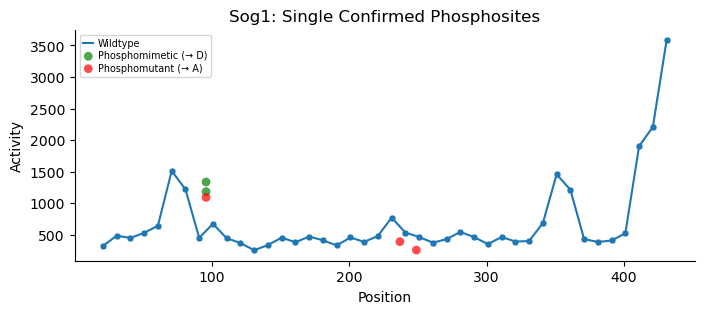

In [100]:
plt.figure(figsize = (8, 3))
sns.lineplot(data = conf2sA_STYA_vs_basic, x = "mid", y = "Activity_S3_1_wt", label = "Wildtype")
sns.scatterplot(data = conf2sA_STYA_vs_basic, x = "mid", y = "Activity_S3_1_wt", s = 25)
sns.scatterplot(data = basic_conf_A_D, x = "var", y = "Activity_S3_1", color = "green",
               alpha = 0.7, s = 40, label = "Phosphomimetic (→ D)", edgecolor = 'none')
sns.scatterplot(data = conf2sA_STYA_vs_basic, x = "var", y = "Activity_S3_1_var", color = "red",
               alpha = 0.7, s = 40, label = "Phosphomutant (→ A)", edgecolor = 'none')


plt.legend(fontsize = 'x-small', handletextpad = 0.5, handlelength = 1, labelspacing = 0.25)
plt.xlabel("Position")
plt.ylabel("Activity")
plt.title("Sog1: Single Confirmed Phosphosites")
sns.despine()

In [248]:
len(activities)

10309

In [ ]:
plt.figure(figsize = (8, 4))
plt.title("Sog1 Full Phosphosite Tiles")
sns.lineplot(data = PSv_conf2fA_STYA, x = "mid", y = "Activity_S3_1", label = "Phosphomutant (→ A)",
            color = sns.color_palette('Dark2')[2])


plt.ylabel("Activity")
plt.xlabel("Position")
plt.legend(fontsize = 'x-small')
sns.despine()

In [90]:
library["Description"] = library["Description"].astype(str)

In [104]:
library["Description"].value_counts().head(10)

Description
32_CHA_DEtoA_duos         105
32_CHA_dead_AtoDE_duos    105
33_CHA_DEtoA_duos          78
33_CHA_dead_AtoDE_duos     78
34_CHA_DEtoA_duos          49
34_CHA_dead_AtoDE_duos     49
8_Ascan_comb               46
8_Dscan_comb               46
8_Kscan_comb               46
8_Pscan_comb               46
Name: count, dtype: int64

In [114]:
library[library["Description"].str.contains("PSv_max2A_STYA")]

,ProteinSeq,Description,Other
13170,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,1_PSv_max2A_STYA,NaN
13171,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,2_PSv_max2A_STYA,NaN
13172,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,3_PSv_max2A_STYA,NaN
13173,WKANPARHCPKCQHVIDNADVVDDWPGLPRGVKFDPADPE,4_PSv_max2A_STYA,NaN
13174,KCQHVIDNADVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,5_PSv_max2A_STYA,NaN
13175,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,6_PSv_max2A_STYA,NaN
13176,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,7_PSv_max2A_STYA,NaN
13177,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICAAHPKN,8_PSv_max2A_STYA,PS:Y(!)x1
13178,LAGLAAHPFIDEFIPAVNQDDGICAAHPKNLPGVKADGAV,9_PSv_max2A_STYA,PS:Y(!)x1
13179,DEFIPAVNQDDGICAAHPKNLPGVKADGAVAHFFHKAIKA,10_PSv_max2A_STYA,PS:Y(!)x1


In [110]:
library[library["Description"].str.contains("PSv_max2A_STAYF")]

,ProteinSeq,Description,Other
13346,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,1_PSv_max2A_STAYF,NaN
13347,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,2_PSv_max2A_STAYF,NaN
13348,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,3_PSv_max2A_STAYF,NaN
13349,WKANPARHCPKCQHVIDNADVVDDWPGLPRGVKFDPADPE,4_PSv_max2A_STAYF,NaN
13350,KCQHVIDNADVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,5_PSv_max2A_STAYF,NaN
13351,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,6_PSv_max2A_STAYF,NaN
13352,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,7_PSv_max2A_STAYF,NaN
13353,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICFAHPKN,8_PSv_max2A_STAYF,PS:Y(!)x1
13354,LAGLAAHPFIDEFIPAVNQDDGICFAHPKNLPGVKADGAV,9_PSv_max2A_STAYF,PS:Y(!)x1
13355,DEFIPAVNQDDGICFAHPKNLPGVKADGAVAHFFHKAIKA,10_PSv_max2A_STAYF,PS:Y(!)x1


In [94]:
library[library["Description"].str.contains("PSv_pred2A_STYA")]

,ProteinSeq,Description,Other
13212,MAGRSWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,1_PSv_pred2A_STYA,NaN
13213,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNSD,2_PSv_pred2A_STYA,NaN
13214,AAAADPRQVVWKANPARHCPKCQHVIDNSDVVDDWPGLPR,3_PSv_pred2A_STYA,NaN
13215,WKANPARHCPKCQHVIDNSDVVDDWPGLPRGVKFDPADPE,4_PSv_pred2A_STYA,NaN
13216,KCQHVIDNSDVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,5_PSv_pred2A_STYA,NaN
13217,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,6_PSv_pred2A_STYA,NaN
13218,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,7_PSv_pred2A_STYA,NaN
13219,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICYAHPKN,8_PSv_pred2A_STYA,PS:Y(!)x1
13220,LAGLAAHPFIDEFIPAVNQDDGICYAHPKNLPGVKADGTV,9_PSv_pred2A_STYA,PS:Y(!)x1
13221,DEFIPAVNQDDGICYAHPKNLPGVKADGTVAHFFHKAIKA,10_PSv_pred2A_STYA,PS:Y(!)x1


In [96]:
library[library["Description"].str.contains("PSv_conf2sA_STYA")]

,ProteinSeq,Description,Other
13254,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,7_PSv_conf2sA_STYA,NaN
13255,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,8_PSv_conf2sA_STYA,NaN
13256,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,9_PSv_conf2sA_STYA,NaN
13257,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,10_PSv_conf2sA_STYA,NaN
13258,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVAPTA,21_PSv_conf2sA_STYA,NaN
13259,QQPQQLVVKRGDKAEQEVSEDIFAAVAPTADPVTPKLATP,22_PSv_conf2sA_STYA,NaN
13260,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVAPKLATP,22_PSv_conf2sA_STYA,NaN
13261,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLAAP,22_PSv_conf2sA_STYA,NaN
13262,GDKAEQEVSEDIFAAVAPTADPVTPKLATPEPRNAVRICS,23_PSv_conf2sA_STYA,NaN
13263,GDKAEQEVSEDIFAAVTPTADPVAPKLATPEPRNAVRICS,23_PSv_conf2sA_STYA,NaN


In [67]:
def return_activities(filepath):
    return_tiles = pd.read_csv(filepath, sep = "\t")
    
    return_tiles = return_tiles.rename(columns = {"AA sequence" : "tile"})
    return_tiles["Start"] = return_tiles["AA interval"].str.split("-").str[0].astype(int)
    return_tiles["End"] = return_tiles["AA interval"].str.split("-").str[1].astype(int)
    return_tiles["mid"] = (return_tiles["Start"] + return_tiles["End"]) / 2
    return_tiles["tile"] = return_tiles["tile"].astype(str).str.strip()
    
    activities = pd.read_csv("../data/Sog1_library2_activities_with_reads.csv")
    activities = activities.rename(columns = {"AAseq" : "tile"})
    activities["tile"] = activities["tile"].astype(str).str.strip()

    return pd.merge(return_tiles, activities[["tile", "Activity_S3_1"]], on = "tile")

In [68]:
wt_activ = return_activities("../data/wt_tiles.csv")
wt_activ

,Tile ID,AA interval,Length,SOG1 partim,tile,Remarks,Start,End,mid,Activity_S3_1
0,1,1-40,40,NTD,MAGRSWLIDSNRIATKIMSASASSDPRQVVWKSNPSRHCP,/,1,40,20.5,349.798825
1,2,11-50,40,NTD,NRIATKIMSASASSDPRQVVWKSNPSRHCPKCQHVIDNSD,/,11,50,30.5,470.700956
2,3,21-60,40,NTD + NAC,SASSDPRQVVWKSNPSRHCPKCQHVIDNSDVVDDWPGLPR,/,21,60,40.5,867.654700
3,4,31-70,40,NTD + NAC,WKSNPSRHCPKCQHVIDNSDVVDDWPGLPRGVKFDPSDPE,/,31,70,50.5,594.934332
4,5,41-80,40,NTD + NAC,KCQHVIDNSDVVDDWPGLPRGVKFDPSDPEIIWHLLAKSG,/,41,80,60.5,667.974526
5,6,51-90,40,NTD + NAC,VVDDWPGLPRGVKFDPSDPEIIWHLLAKSGLSGLSSHPFI,/,51,90,70.5,1548.153317
6,7,61-100,40,NAC,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPTVNQD,/,61,100,80.5,1195.592810
7,8,71-110,40,NAC,IIWHLLAKSGLSGLSSHPFIDEFIPTVNQDDGICYTHPKN,/,71,110,90.5,553.464718
8,9,81-120,40,NAC,LSGLSSHPFIDEFIPTVNQDDGICYTHPKNLPGVKSDGTV,/,81,120,100.5,733.541576
9,10,91-130,40,NAC,DEFIPTVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,/,91,130,110.5,495.092751


In [69]:
max_A_phosphomut = return_activities("../data/maximal_A_phosphomutant.tsv")
max_A_phosphomut

,Tile ID,AA interval,Length,SOG1 partim,Description,tile,Remarks,Start,End,mid,Activity_S3_1
0,NaN,1-40,40,NTD,1_PSv_maxA_STYA,MAGRAWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,NaN,1,40,20.5,2221.077253
1,NaN,11-50,40,NTD,2_PSv_maxA_STYA,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNAD,NaN,11,50,30.5,571.070293
2,NaN,21-60,40,NTD + NAC,3_PSv_maxA_STYA,AAAADPRQVVWKANPARHCPKCQHVIDNADVVDDWPGLPR,NaN,21,60,40.5,767.843899
3,NaN,31-70,40,NTD + NAC,4_PSv_maxA_STYA,WKANPARHCPKCQHVIDNADVVDDWPGLPRGVKFDPADPE,NaN,31,70,50.5,325.410474
4,NaN,41-80,40,NTD + NAC,5_PSv_maxA_STYA,KCQHVIDNADVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,NaN,41,80,60.5,564.295027
5,NaN,51-90,40,NTD + NAC,6_PSv_maxA_STYA,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,NaN,51,90,70.5,2777.904051
6,NaN,61-100,40,NAC,7_PSv_maxA_STYA,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,NaN,61,100,80.5,1278.976936
7,NaN,71-110,40,NAC,8_PSv_maxA_STYA,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICAAHPKN,PS:Y(!)x1,71,110,90.5,2351.808451
8,NaN,81-120,40,NAC,9_PSv_maxA_STYA,LAGLAAHPFIDEFIPAVNQDDGICAAHPKNLPGVKADGAV,PS:Y(!)x1,81,120,100.5,1174.051945
9,NaN,91-130,40,NAC,10_PSv_maxA_STYA,DEFIPAVNQDDGICAAHPKNLPGVKADGAVAHFFHKAIKA,PS:Y(!)x1,91,130,110.5,4167.296694


In [70]:
full_A_phosphomut = return_activities("../data/full_A_phosphomutant.tsv")
full_A_phosphomut

,Tile ID,AA interval,Length,SOG1 partim,Description,tile,Remarks,Start,End,mid,Activity_S3_1
0,NaN,1-40,40,NTD,1_PSv_predA_STYA,MAGRSWLIDANRIAAKIMAAAAAADPRQVVWKANPARHCP,NaN,1,40,20.5,280.882059
1,NaN,11-50,40,NTD,2_PSv_predA_STYA,NRIAAKIMAAAAAADPRQVVWKANPARHCPKCQHVIDNSD,NaN,11,50,30.5,316.923054
2,NaN,21-60,40,NTD + NAC,3_PSv_predA_STYA,AAAADPRQVVWKANPARHCPKCQHVIDNSDVVDDWPGLPR,NaN,21,60,40.5,297.992003
3,NaN,31-70,40,NTD + NAC,4_PSv_predA_STYA,WKANPARHCPKCQHVIDNSDVVDDWPGLPRGVKFDPADPE,NaN,31,70,50.5,402.366669
4,NaN,41-80,40,NTD + NAC,5_PSv_predA_STYA,KCQHVIDNSDVVDDWPGLPRGVKFDPADPEIIWHLLAKSG,NaN,41,80,60.5,320.632032
5,NaN,51-90,40,NTD + NAC,6_PSv_predA_STYA,VVDDWPGLPRGVKFDPADPEIIWHLLAKAGLAGLAAHPFI,NaN,51,90,70.5,2777.904051
6,NaN,61-100,40,NAC,7_PSv_predA_STYA,GVKFDPADPEIIWHLLAKAGLAGLAAHPFIDEFIPAVNQD,NaN,61,100,80.5,1278.976936
7,NaN,71-110,40,NAC,8_PSv_predA_STYA,IIWHLLAKAGLAGLAAHPFIDEFIPAVNQDDGICYAHPKN,PS:Y(!)x1,71,110,90.5,2365.051074
8,NaN,81-120,40,NAC,9_PSv_predA_STYA,LAGLAAHPFIDEFIPAVNQDDGICYAHPKNLPGVKADGTV,PS:Y(!)x1,81,120,100.5,610.609357
9,NaN,91-130,40,NAC,10_PSv_predA_STYA,DEFIPAVNQDDGICYAHPKNLPGVKADGTVAHFFHKAIKA,PS:Y(!)x1,91,130,110.5,618.169787


In [71]:
confirmed_A_phosphomut = return_activities("../data/confirmed_A_phosphomutant.tsv")
confirmed_A_phosphomut

,Tile ID,AA interval,Length,SOG1 partim,Description,tile,Remarks,Start,End,mid,Activity_S3_1
0,NaN,61-100,40,NAC,7_PSv_confsA_STYA,GVKFDPSDPEIIWHLLAKSGLSGLSSHPFIDEFIPAVNQD,NaN,61,100,80.5,938.283433
1,NaN,71-110,40,NAC,8_PSv_confsA_STYA,IIWHLLAKSGLSGLSSHPFIDEFIPAVNQDDGICYTHPKN,NaN,71,110,90.5,NaN
2,NaN,81-120,40,NAC,9_PSv_confsA_STYA,LSGLSSHPFIDEFIPAVNQDDGICYTHPKNLPGVKSDGTV,NaN,81,120,100.5,1858.333362
3,NaN,91-130,40,NAC,10_PSv_confsA_STYA,DEFIPAVNQDDGICYTHPKNLPGVKSDGTVSHFFHKAIKA,NaN,91,130,110.5,NaN
4,NaN,201-240,40,NAC + CTD,21_PSv_confsA_STYA,GDYVVSKIFYQQPQQLVVKRGDKAEQEVSEDIFAAVAPTA,NaN,201,240,220.5,2760.512552
5,NaN,211-250,40,NAC + CTD,22_PSv_confsA_STYA,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVAPKLATP,NaN,211,250,230.5,463.613666
6,NaN,211-250,40,NAC + CTD,22_PSv_confsA_STYA,QQPQQLVVKRGDKAEQEVSEDIFAAVTPTADPVTPKLAAP,NaN,211,250,230.5,923.329508
7,NaN,221-260,40,CTD,23_PSv_confsA_STYA,GDKAEQEVSEDIFAAVTPTADPVAPKLATPEPRNAVRICS,NaN,221,260,240.5,496.086024
8,NaN,221-260,40,CTD,23_PSv_confsA_STYA,GDKAEQEVSEDIFAAVTPTADPVTPKLAAPEPRNAVRICS,NaN,221,260,240.5,804.327385
9,NaN,231-270,40,CTD,24_PSv_confsA_STYA,DIFAAVAPTADPVTPKLATPEPRNAVRICSDSHIASDYVT,NaN,231,270,250.5,484.727505


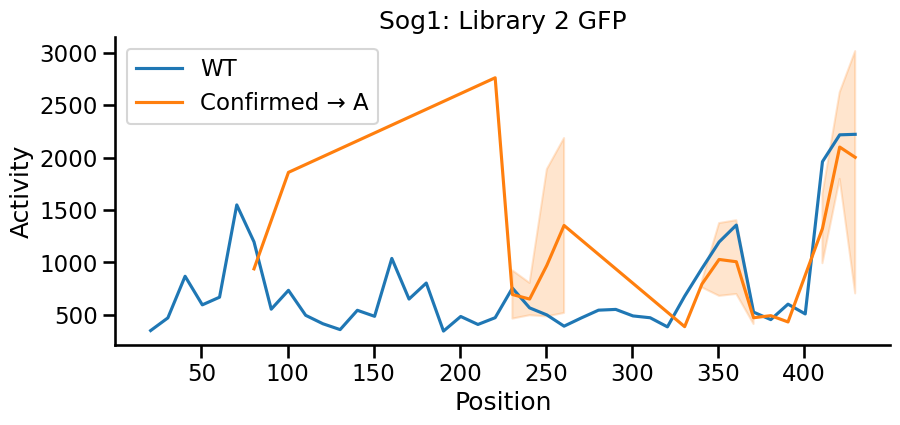

In [111]:
plt.figure(figsize = (10, 4))
sns.set_context('talk')
sns.lineplot(data = wt_activ, x= "mid", y = "Activity_S3_1", label = "WT")
#sns.lineplot(data = max_A_phosphomut, x= "mid", y = "Activity_S3_1", label = "STY → A")
#sns.lineplot(data = full_A_phosphomut, x= "mid", y = "Activity_S3_1", label = "Confirmed + Predicted → A")
sns.lineplot(data = confirmed_A_phosphomut, x= "mid", y = "Activity_S3_1", label = "Confirmed → A")
plt.xlabel("Position")
#plt.ylim(0,  8000)
plt.ylabel("Activity")
plt.title("Sog1: Library 2 GFP")
sns.despine()

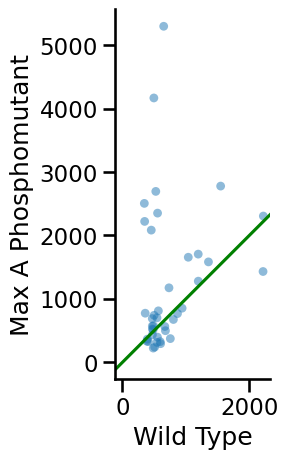

In [30]:
sns.set_context('talk')

merged = pd.merge(wt_activ[["Start", "End", "Activity_S3_1"]], max_A_phosphomut[["Start", "End", "Activity_S3_1"]], on = ["Start", "End"])
plt.gca().set_aspect('equal')
sns.scatterplot(data = merged, x = "Activity_S3_1_x", y = "Activity_S3_1_y", edgecolor = 'none', s = 40, alpha = 0.5)
plt.xlabel("Wild Type")
plt.ylabel("Max A Phosphomutant")
plt.axline([0, 0], slope=1, color = "green")
sns.despine()

,ArrayDNA,Activity_GFP8,Activity_S3_1,Activity_S3_2,reads_S3_1,reads_S3_2,AAseq,lib2_avg,lib2_std
0,GAAGATCCAACTTGGTTTGATTCTGGTTCTCAATTTATCTTAAATT...,636.156202,614.613867,944.856101,6448.0,115.0,EDPTWFDSGSQFILNSQQLVEALSLCDDAAGSQDREENTN,779.734984,233.516523
1,GAAGCTTTGTCTTTGTGTGATGATTTGTTGGGTGATCAAGATAGAG...,602.696194,541.936177,992.565641,10829.0,1680.0,EALSLCDDLLGDQDREENDNDGDLKDKQPCIADYAHLGPE,767.250909,318.643150
2,GATTTGGCTGAAGATGATGAAGTTATGTGTATGGAAGATGAAGTTC...,381.502348,390.255889,390.758385,91062.0,892.0,DLAEDDEVMCMEDEVQSIQPNHERPDDGPELEHGLENGAK,390.507137,0.355319
3,GGTCAAAGGAAGAGAAGGAAGATTACTCCAACTTTGGTTAATGATG...,347.155741,430.848450,865.176167,13900.0,140.0,GQRKRRKITPTLVNDEPVRWHKTGRTKPVMLSGVQRGCKK,648.012309,307.116074
4,TCTGAATTGACTTCTACTTTGGGTATTTCTCATAGATTGCCACAAT...,437.694050,470.823534,3562.821795,10128.0,246.0,SELTSTLGISHRLPQSLTPCVKTGSLQSGGLVQSVPFEEL,2016.822664,2186.372938
...,...,...,...,...,...,...,...,...,...
10304,TTGGAACATGGTTTGGAAAGAGGTGCTAAAGAAATGTTGGATGATA...,NaN,NaN,3570.989020,NaN,11.0,LEHGLERGAKEMLDDKEEREKDRDRERRGEEDPTWFDSGS,3570.989020,NaN
10305,GAAGATGAAGAATGGTTTGATGAAGAAGCTCAATTTATCTTGAATG...,NaN,NaN,3330.752810,NaN,13.0,EDEEWFDEEAQFILNAQQLVEALSLCDDLLGAQDREEEEN,3330.752810,NaN
10306,ACTCAATCTCAATCTTCTAGATCTAGAAATATTCCACCACCACAAG...,NaN,NaN,5347.917675,NaN,11.0,TQSQSSRSRNIPPPQANSSRAREIGNGSKTTMVDEIPMSV,5347.917675,NaN
10307,GACTTTAAGAGAGATTTGGAAGAATGTCAGAAGATTGTCTTGGATC...,NaN,NaN,5545.836977,NaN,21.0,DFKRDLEECQKIVLDPSNIELRPDPETFLSQLEFGSQDSF,5545.836977,NaN
